# Problem Defintion
we are using Linear, Lasso, Non-Linear, Support Vector, and Multli-Linear Regression

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data aquisition

## Gather csv from Google sheets

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

#used to set column names
colnames=['Instance', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1zSM0phlI4Ds_9tBjDGnMgJWyaV9Zw7Qc332e4SItpLo/edit#gid=1838160762')
sheets = gsheets.worksheet('Data for Proj').get_all_values()
df = pd.DataFrame(sheets, columns=colnames)

List of Currency Names

In [4]:
names = []
for i in range(len(df)):
  if df['Symbol'][i] not in names:
    names.append(df['Symbol'][i])

print(names)

['ACP', 'BTBc', 'CKUSD', 'DBG', 'EDR', 'FRGC', 'OP', 'PZM', 'USNBT', 'XSN']


Split currencies into seperate dataframes and change string values to numeric

In [34]:
currencies = {
'ACP':{'train':None, 'test':None},
'BTBc':{'train':None, 'test':None},
'CKUSD':{'train':None, 'test':None},
'DBG':{'train':None, 'test':None},
'EDR':{'train':None, 'test':None},
'FRGC':{'train':None, 'test':None},
'OP':{'train':None, 'test':None},
'PZM':{'train':None, 'test':None},
'USNBT':{'train':None, 'test':None},
'XSN':{'train':None, 'test':None}
}

test_train_split = 0.8

for name in names:
  current = df.loc[df['Symbol']==name]
  last = current.tail(1)
  split_point = int(int(last['Instance'])* test_train_split) + 1
  currencies[name]['train']=current.iloc[:split_point]
  currencies[name]['test']=current.loc[split_point:]

# setting string values to numeric
for coin in currencies:
  for set in currencies[coin]:
    currencies[coin][set].loc[:,['Instance', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']] = currencies[coin][set].loc[:,['Instance', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']].apply(pd.to_numeric)

errorDict = {
  'ACP':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'BTBc':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'CKUSD':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'DBG':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'EDR':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'FRGC':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'OP':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'PZM':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'USNBT':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None},
  'XSN':{'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None}
}

<ipython-input-34-4d178915738e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currencies[coin][set].loc[:,['Instance', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']] = currencies[coin][set].loc[:,['Instance', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']].apply(pd.to_numeric)


## Outlier detection & Replacement

[Implementation](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

[Description](https://medium.com/mlearning-ai/unsupervised-outlier-detection-with-isolation-forest-eab398c593b2)

### Collage plot

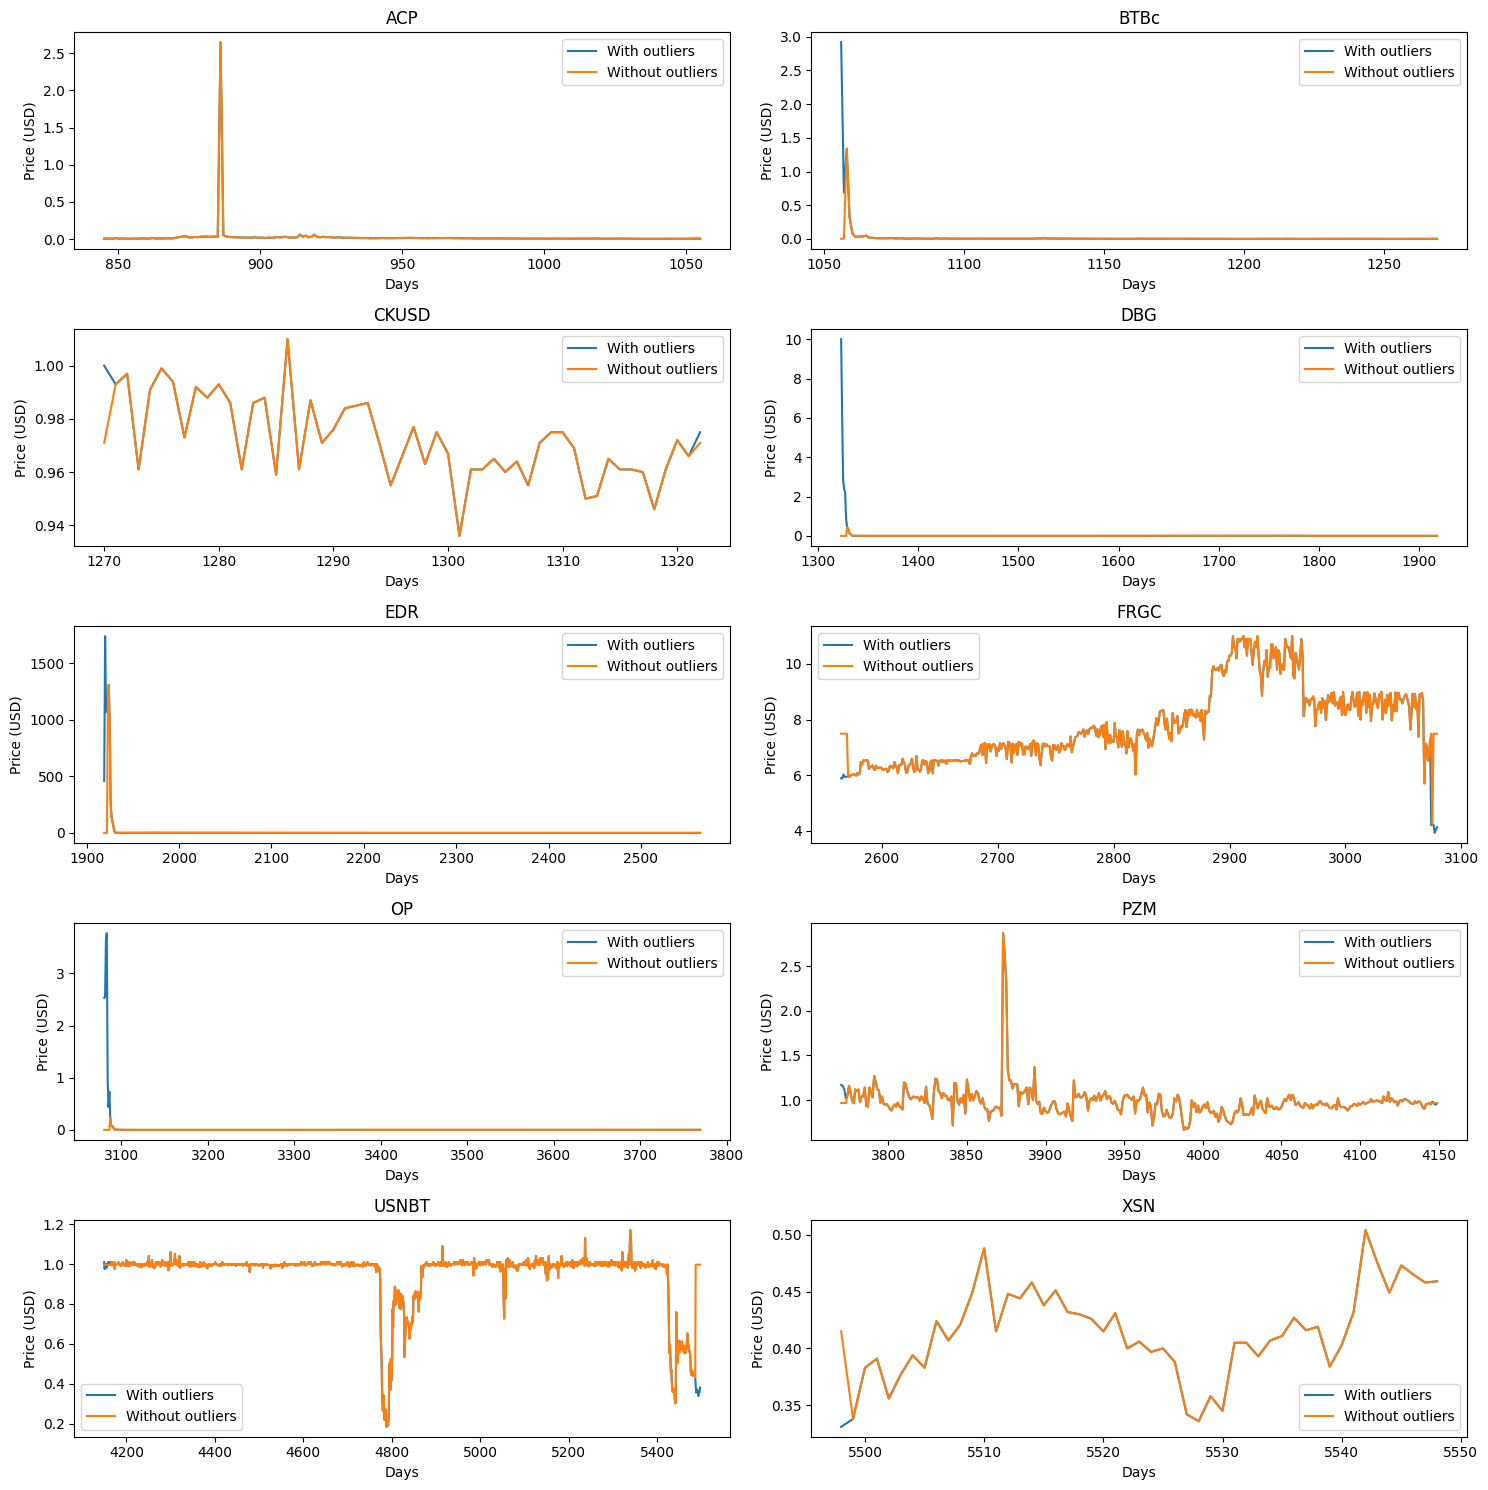

In [23]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/OutlierReplacement/'
john_images_dir = '/content/drive/Starred/484 project/OutlierReplacement/'
for coin in names:
  # Create object
  iso = IsolationForest(contamination=0.02) # contamination represents the amount of outliers in the set
  # reshape test X variable
  outlierX = np.array([float(i) for i in range(len(currencies[coin]['test']['Open']))])
  outlierX = outlierX.reshape(-1, 1)
  # identify outliers in the test dataset
  yhat = iso.fit_predict(outlierX)
  #print(yhat) # list of -1 (outliers) or 1 (non-outlier)
  # replacing outliers with global mean
  newarr = []
  for i in range(len(currencies[coin]['test']['Open'])):
    if yhat[i] == -1:
      newarr.append(currencies[coin]['test']['Open'].median())
    else:
      newarr.append(currencies[coin]['test']['Open'].iloc[i])
  # get range of x values
  ind = currencies[coin]['test']['Open'].index
  # plot and check difference
  #print(coin)
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], label='With outliers')
  ax[subs[sub][0], subs[sub][1]].plot(range(ind[0], ind.size+ind[0]), newarr, label='Without outliers')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  # save plot in drive
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plots

ACP


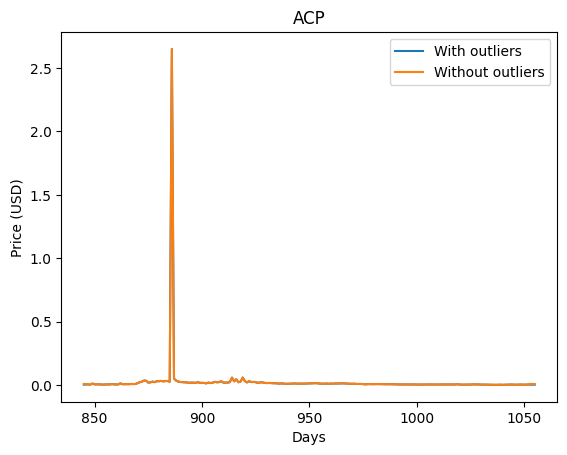

BTBc


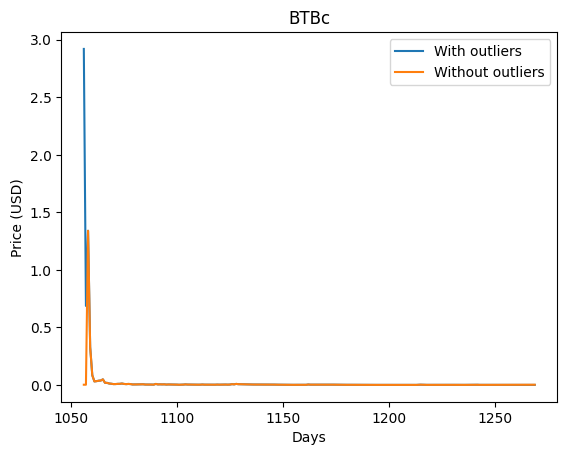

CKUSD


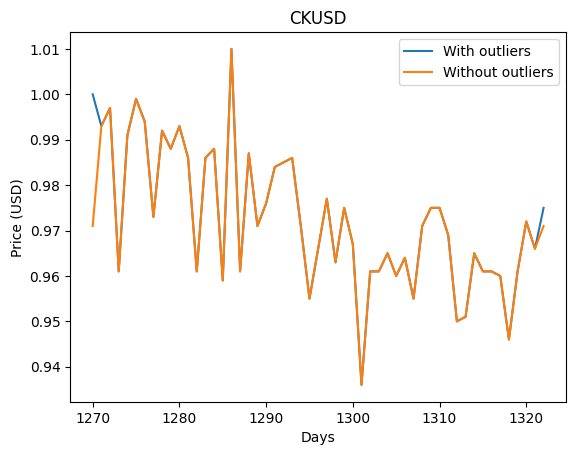

DBG


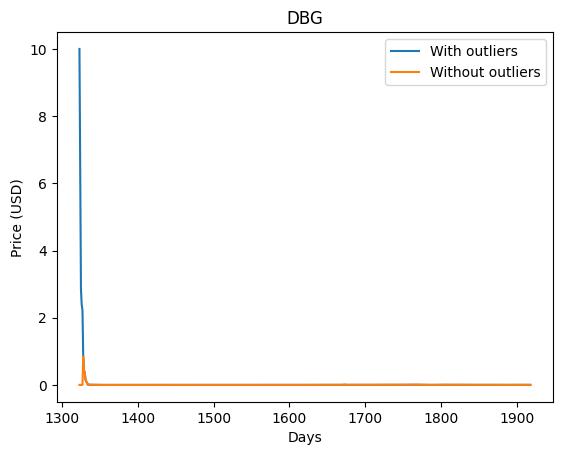

EDR


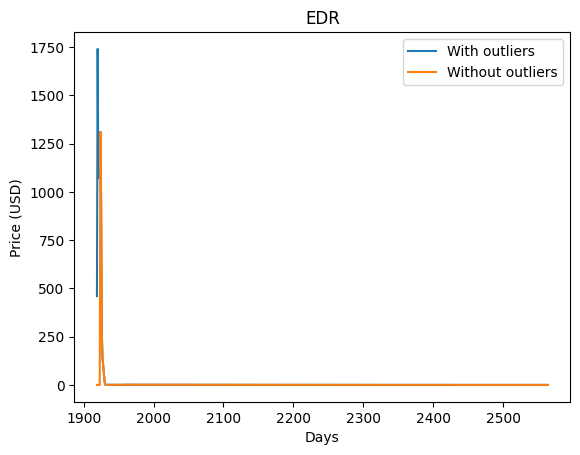

FRGC


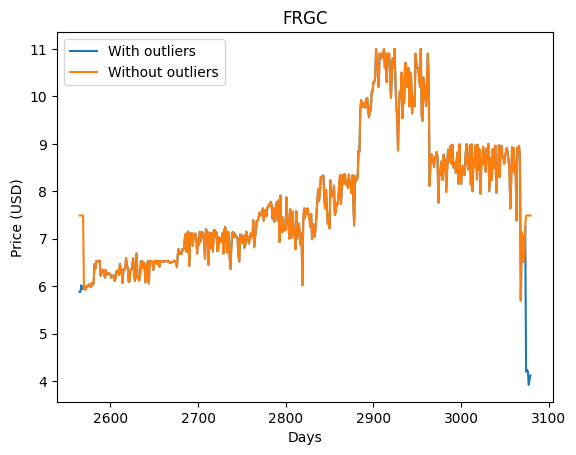

OP


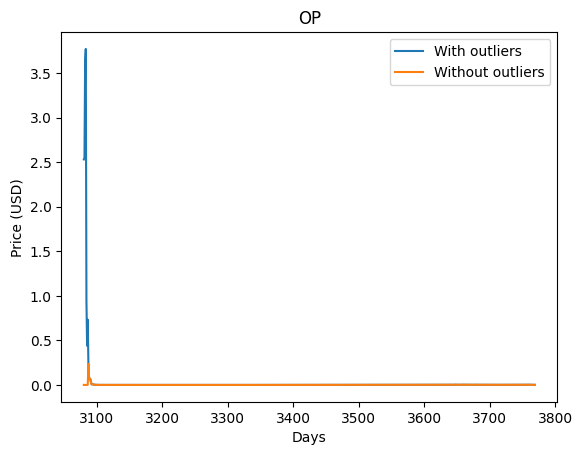

PZM


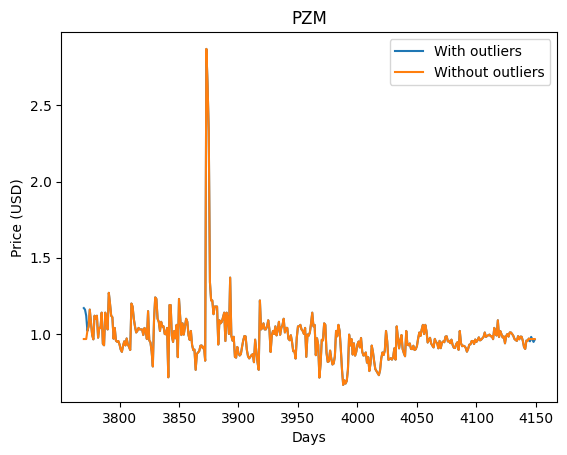

USNBT


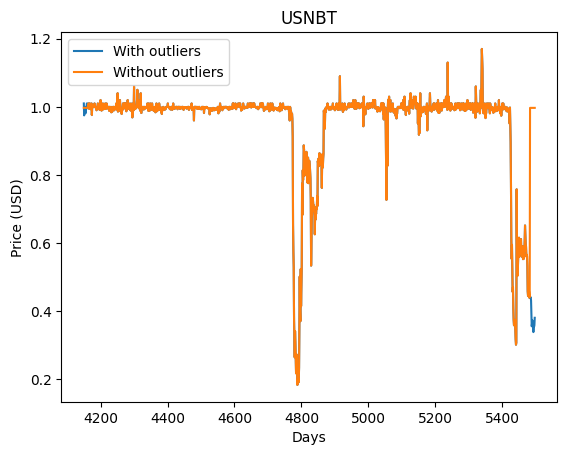

XSN


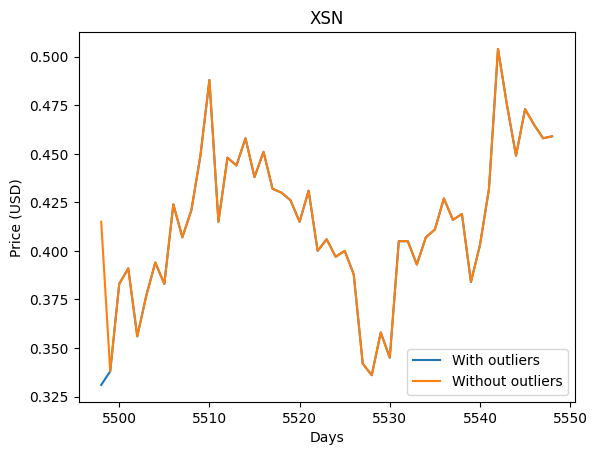

In [35]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/OutlierReplacement/'
john_images_dir = '/content/drive/Starred/484 project/OutlierReplacement/'
for coin in names:
  # Create object
  iso = IsolationForest(contamination=0.02) # contamination represents the amount of outliers in the set
  # reshape test X variable
  outlierX = np.array([float(i) for i in range(len(currencies[coin]['test']['Open']))])
  outlierX = outlierX.reshape(-1, 1)
  # identify outliers in the test dataset
  yhat = iso.fit_predict(outlierX)
  #print(yhat) # list of -1 (outliers) or 1 (non-outlier)
  # replacing outliers with global mean
  newarr = []
  for i in range(len(currencies[coin]['test']['Open'])):
    if yhat[i] == -1:
      newarr.append(currencies[coin]['test']['Open'].median())
    else:
      newarr.append(currencies[coin]['test']['Open'].iloc[i])
  # get range of x values
  ind = currencies[coin]['test']['Open'].index
  # plot and check difference
  print(coin)
  plt.plot(currencies[coin]['test']['Open'], label='With outliers')
  plt.plot(range(ind[0], ind.size+ind[0]), newarr, label='Without outliers')
  plt.legend()
  plt.ylabel('Price (USD)')
  plt.xlabel('Days')
  plt.title(coin)
  # save plot in drive
  plt.savefig(will_images_dir+coin)
  plt.show()
  #plt.savefig(john_images_dir+coin)
  # replace original data with no outlier data
  s = pd.Series(newarr)
  s.reindex(range(ind[0], ind.size+ind[0]))
  currencies[coin]['test']['Open'] = s.values

checking to see if series without outliers is saved in df

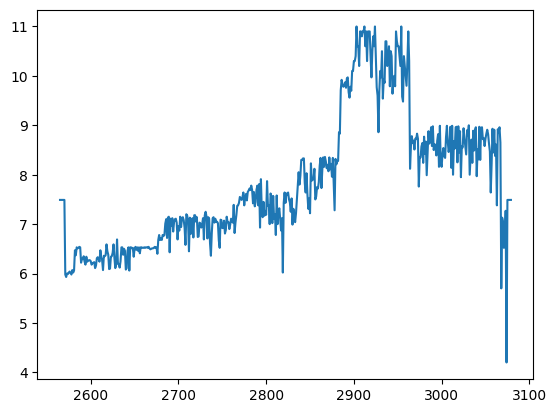

In [ ]:
plt.plot(currencies['FRGC']['test']['Open'])

# Regressions

## Linear Regression

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

### Collage plot

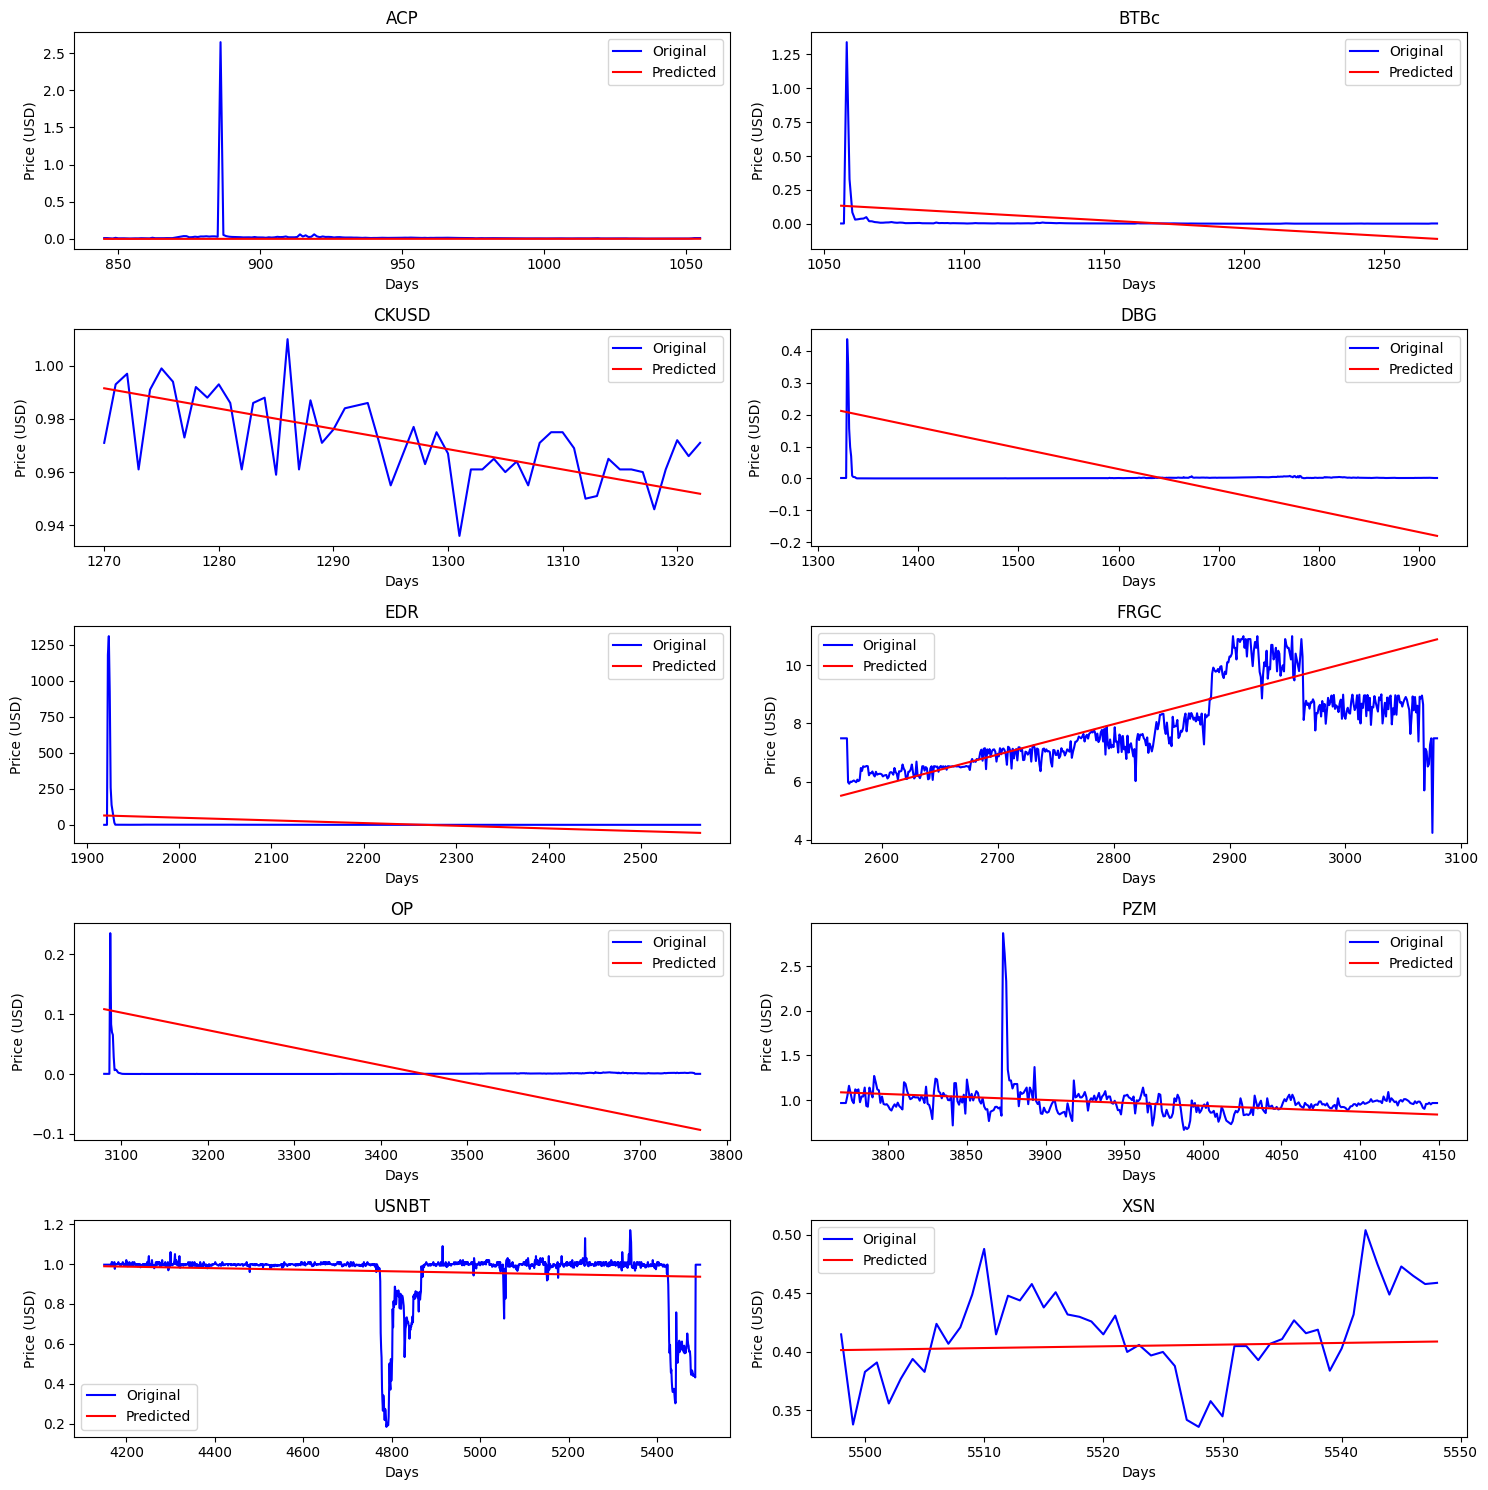

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/LinearImages/'
john_images_dir = '/content/drive/Starred/484 project/LinearImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create linear model
  linearModel = LinearRegression()
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  linearModel.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  linearPreds = linearModel.predict(testX)
  # plot predictions
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
  ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),linearPreds, color='r', label='Predicted')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plots

ACP
Mean Squared Error: 0.03360096148561545 Adjusted R-squared: -0.021285914078919888


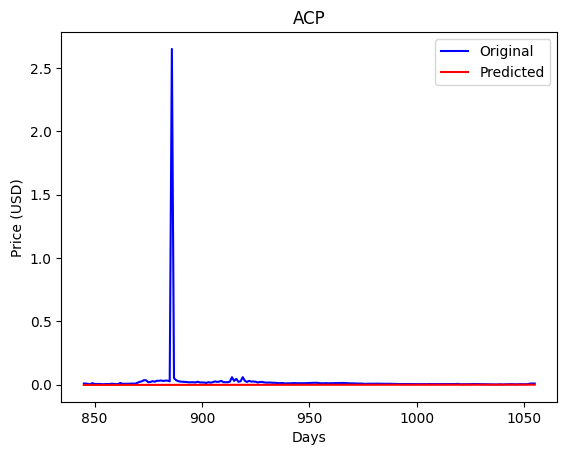

BTBc
Mean Squared Error: 0.01148853689780381 Adjusted R-squared: -0.30002881206285537


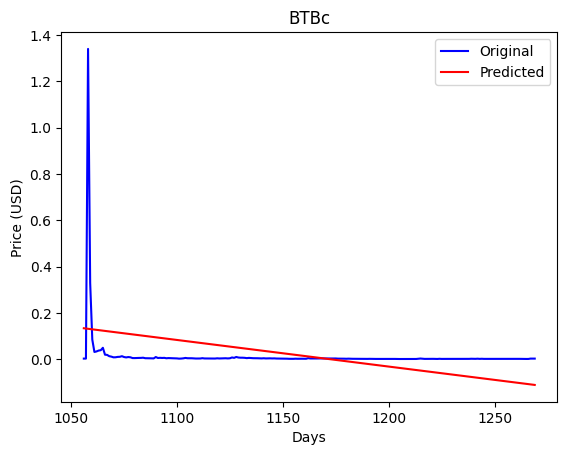

CKUSD
Mean Squared Error: 0.00014851025217499855 Adjusted R-squared: 0.33775086699691326


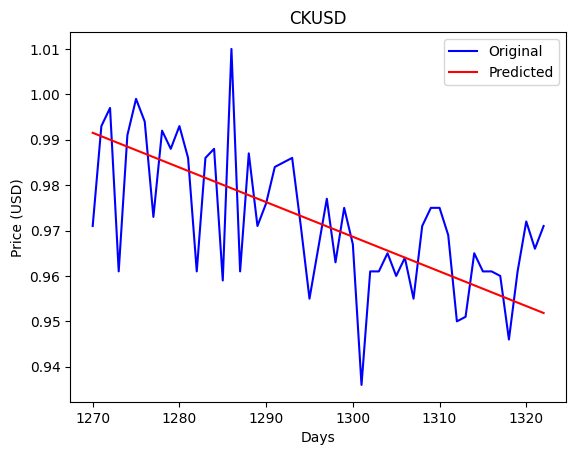

DBG
Mean Squared Error: 0.013704551642714996 Adjusted R-squared: -6.6882783226558695


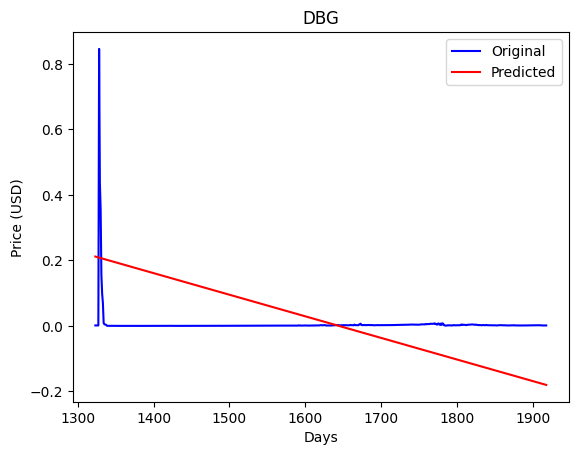

EDR
Mean Squared Error: 4795.411642734194 Adjusted R-squared: -0.1677169171336821


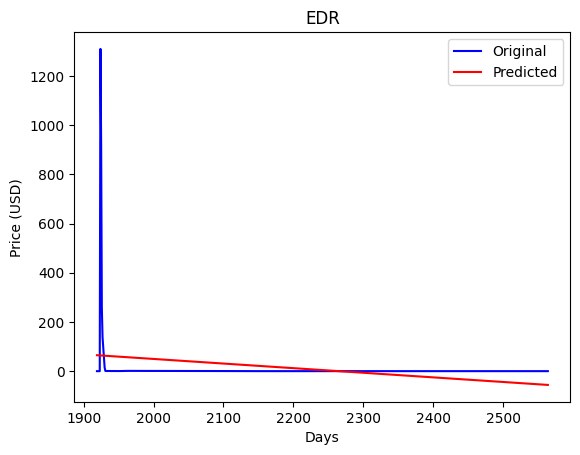

FRGC
Mean Squared Error: 1.3001665220164302 Adjusted R-squared: 0.25905038068049746


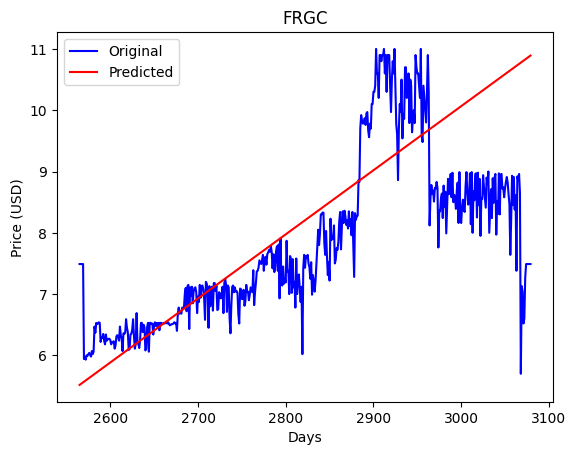

OP
Mean Squared Error: 0.0034502920077999094 Adjusted R-squared: -32.28552714768791


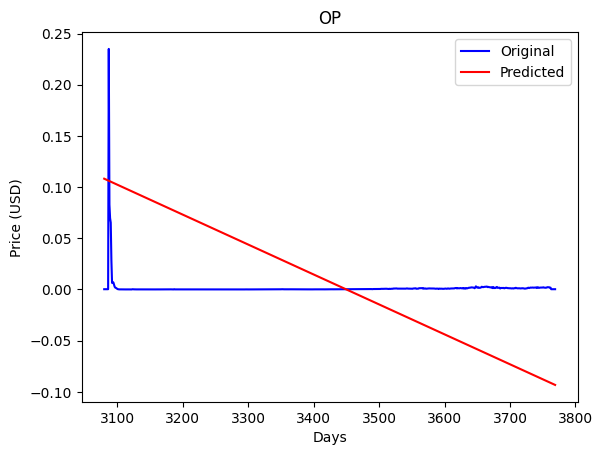

PZM
Mean Squared Error: 0.03214905030001399 Adjusted R-squared: 0.007307745073821481


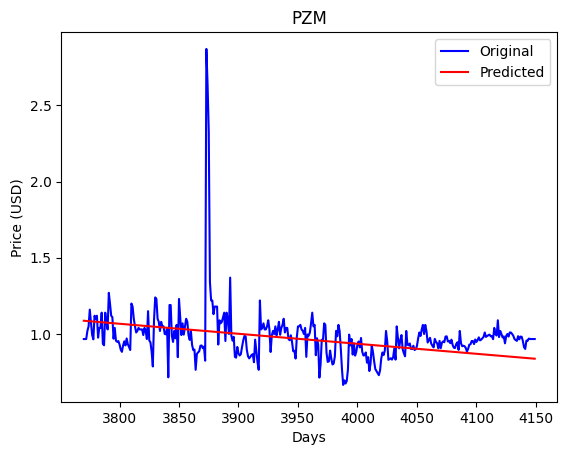

USNBT
Mean Squared Error: 0.018957566247291075 Adjusted R-squared: 0.03324093172365816


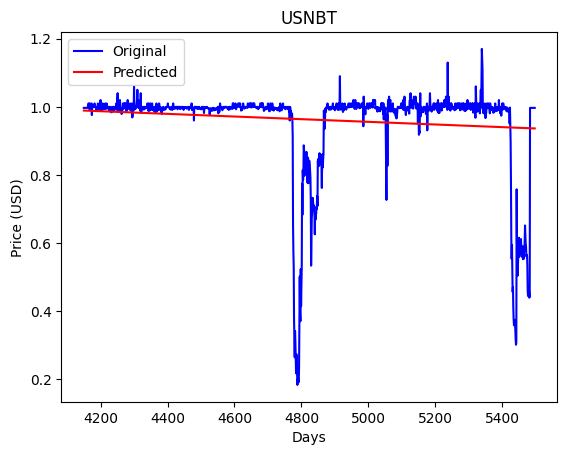

XSN
Mean Squared Error: 0.001484487789892875 Adjusted R-squared: -0.03672028656257664


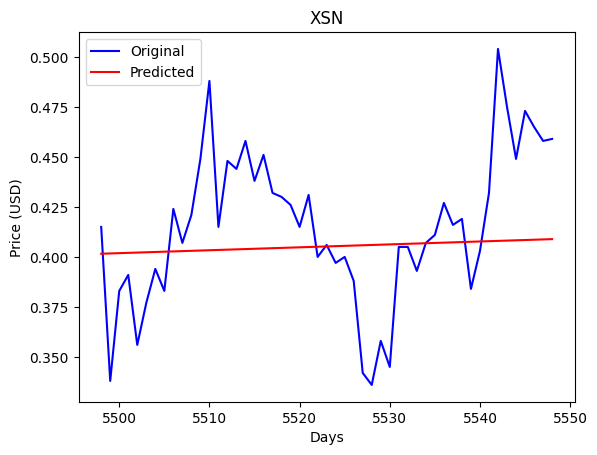

In [46]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/LinearImages/'
john_images_dir = '/content/drive/Starred/484 project/LinearImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create linear model
  linearModel = LinearRegression()
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  linearModel.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  linearPreds = linearModel.predict(testX)
  # calculate and save error rate in MSE & adjusted R-squared
  rSquared = r2_score(currencies[coin]['test']['Open'], linearPreds)
  error = [mean_squared_error(currencies[coin]['test']['Open'], linearPreds), rSquared]
  errorDict[coin]['linear'] = error
  # plot predictions
  print(coin)
  print("Mean Squared Error:",error[0], "Adjusted R-squared:", error[1])
  plt.plot(currencies[coin]['test']['Open'], color='b', label='Original')
  plt.plot(range(test_ind[0], test_ind.size+test_ind[0]),linearPreds, color='r', label='Predicted')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price (USD)')
  plt.title(coin)
  plt.savefig(will_images_dir+coin)
  #plt.savefig(john_images_dir+coin)
  plt.show()

## Lasso Regression

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

[Implementation](https://machinelearningmastery.com/lasso-regression-with-python/)

### Collage plots

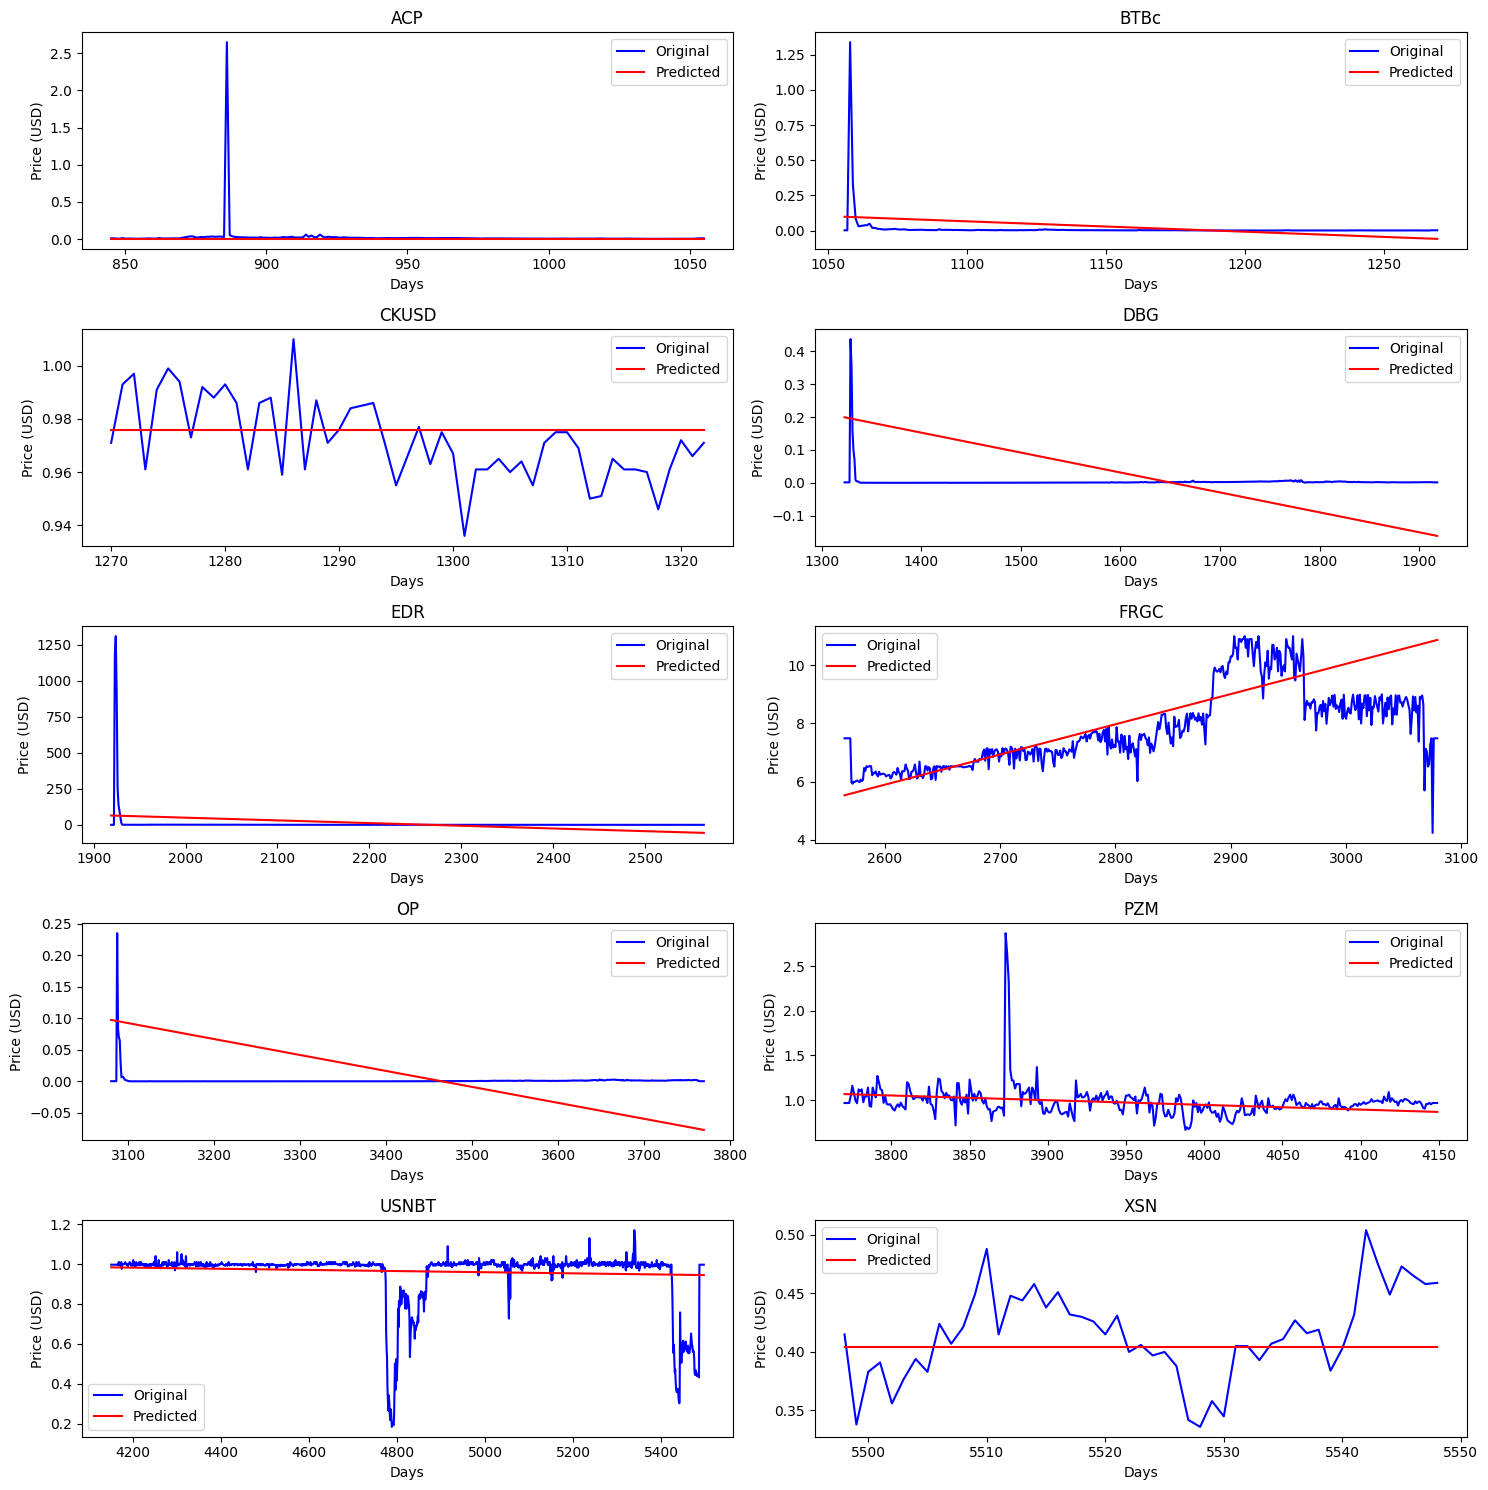

In [29]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/LassoImages/'
john_images_dir = '/content/drive/Starred/484 project/LassoImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create lasso model
  lassoModel = linear_model.Lasso(alpha=1.0)
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  lassoModel.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  lassoPreds = lassoModel.predict(testX)
  # show predictions and error
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
  ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),lassoPreds, color='r', label='Predicted')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plots

ACP
Mean Squared Error: 0.033439656613776944 R-squared: -0.016383125997945003


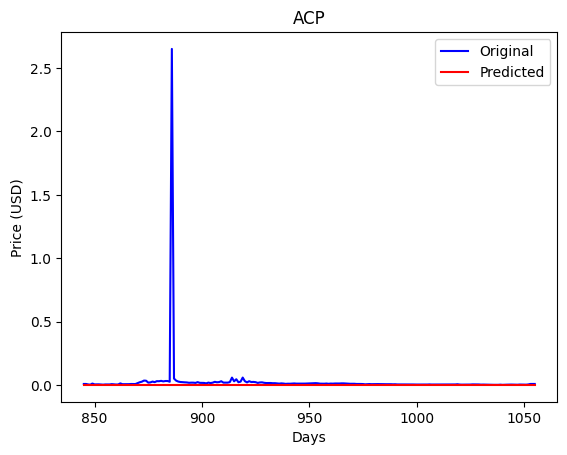

BTBc
Mean Squared Error: 0.009445997682380226 R-squared: -0.06889756763724675


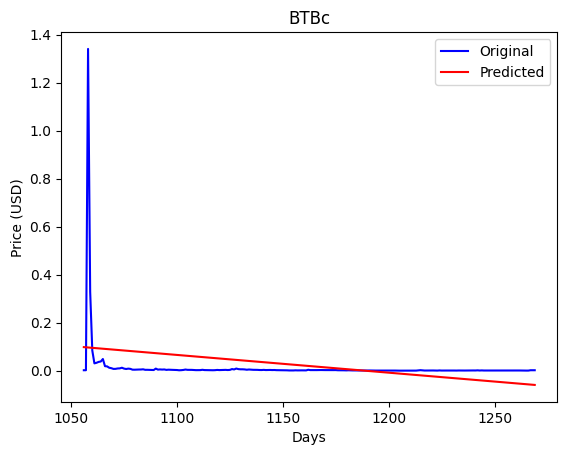

CKUSD
Mean Squared Error: 0.00023844723612715586 R-squared: -0.06330353008972534


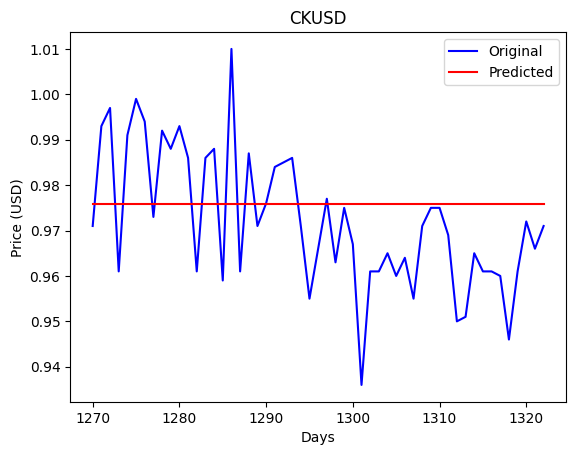

DBG
Mean Squared Error: 0.011891869292176675 R-squared: -5.671360236983733


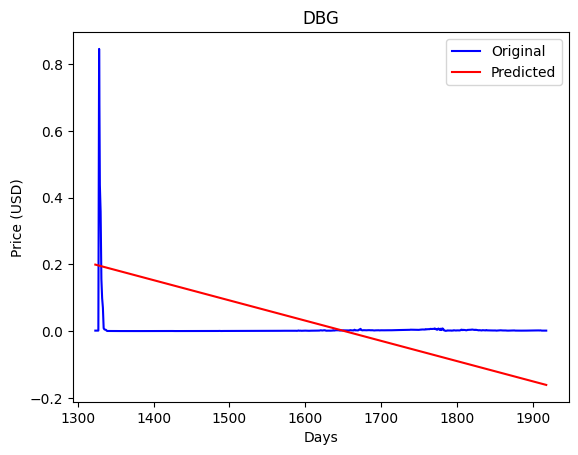

EDR
Mean Squared Error: 4794.953471386526 R-squared: -0.1676053491446381


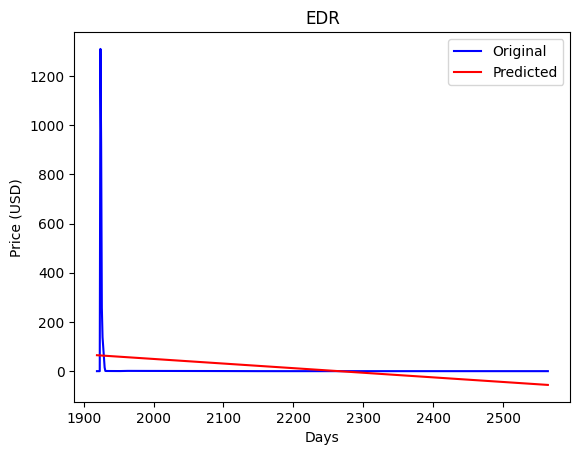

FRGC
Mean Squared Error: 1.28525371849855 R-squared: 0.2675490121268934


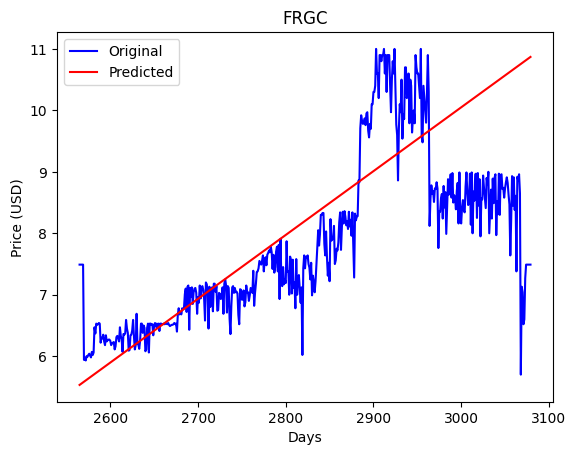

OP
Mean Squared Error: 0.0026502678351784255 R-squared: -24.567564071983142


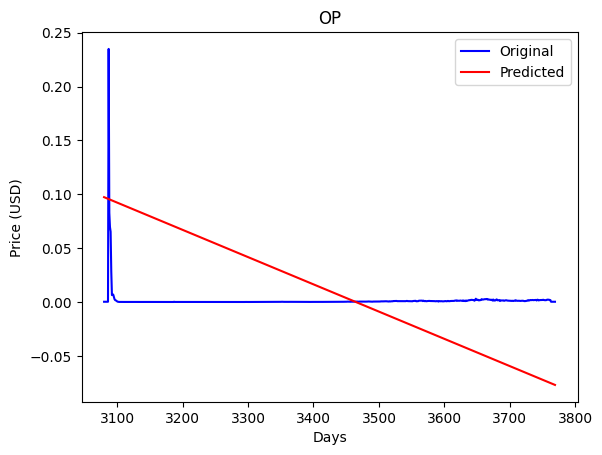

PZM
Mean Squared Error: 0.03128061167411394 R-squared: 0.034123227639082265


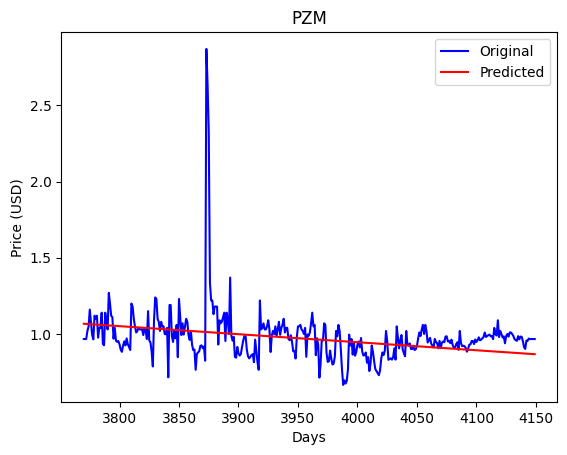

USNBT
Mean Squared Error: 0.019128893506773628 R-squared: 0.02450393565638298


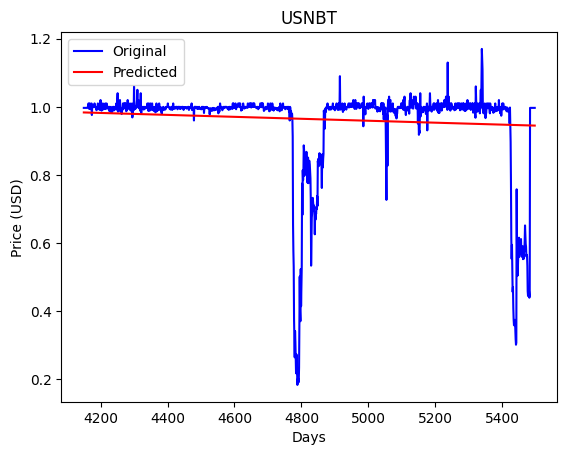

XSN
Mean Squared Error: 0.0015443833385823092 R-squared: -0.07854948234573222


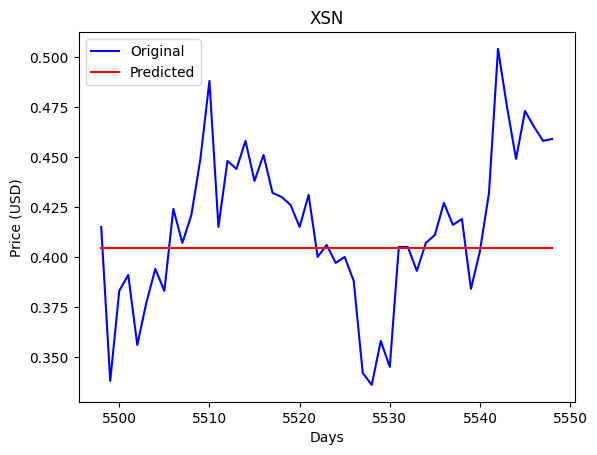

In [45]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/LassoImages/'
john_images_dir = '/content/drive/Starred/484 project/LassoImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create lasso model
  lassoModel = linear_model.Lasso(alpha=1.0)
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  lassoModel.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  lassoPreds = lassoModel.predict(testX)
  # calculate and save error rate in MSE
  error = [mean_squared_error(currencies[coin]['test']['Open'], lassoPreds), r2_score(currencies[coin]['test']['Open'], lassoPreds)]
  errorDict[coin]['lasso'] = error
  # show predictions and error
  print(coin)
  print("Mean Squared Error:",error[0], "R-squared:", error[1])
  plt.plot(currencies[coin]['test']['Open'], color='b', label='Original')
  plt.plot(range(test_ind[0], test_ind.size+test_ind[0]),lassoPreds, color='r', label='Predicted')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price (USD)')
  plt.title(coin)
  plt.savefig(will_images_dir+coin)
  #plt.savefig(john_images_dir+coin)
  plt.show()

## Non-linear - Polynomial Regression

[Implementation](https://www.statology.org/sklearn-polynomial-regression/)

### Collage plot

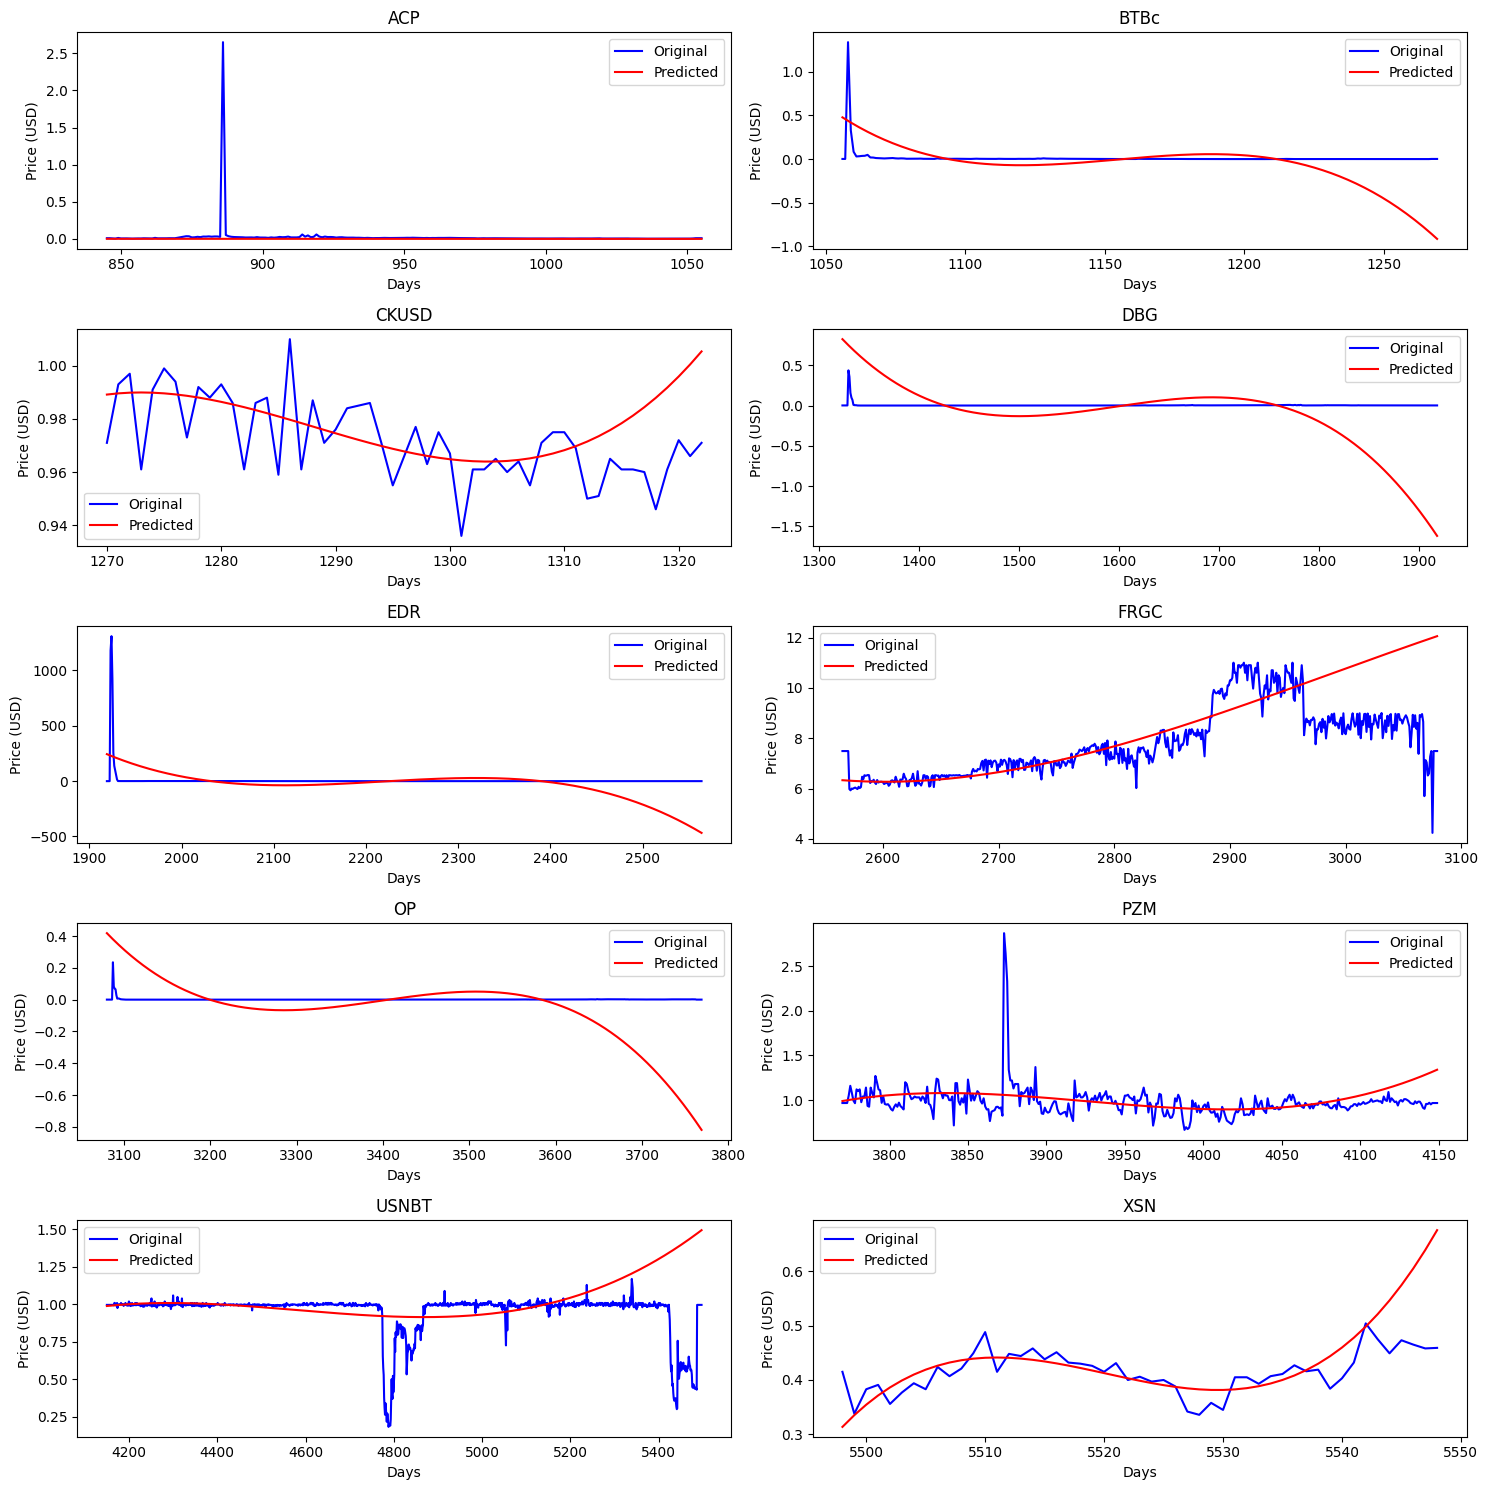

In [31]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/PolyImages/'
john_images_dir = '/content/drive/Starred/484 project/PolyImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # gather polynomial features
  poly = PolynomialFeatures(degree=3, include_bias=False)
  poly_features = poly.fit_transform(trainX)
  # create poly model
  poly_reg_model = LinearRegression()
  # fit to training data
  poly_reg_model.fit(poly_features, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # gather polynomial features
  poly_features = poly.fit_transform(testX)
  # predict testing data from instances
  polyPreds = poly_reg_model.predict(poly_features)
  # plot predictions
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
  ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),polyPreds, color='r', label='Predicted')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plot

ACP
Mean Squared Error: 0.033522164032022406 R-squared: -0.018890901381015013


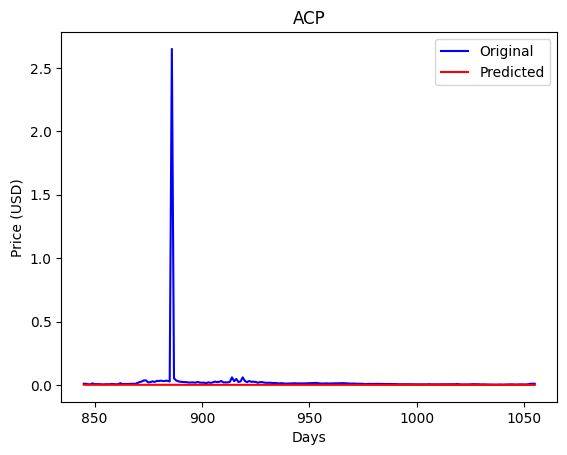

BTBc
Mean Squared Error: 0.06500531836118681 R-squared: -6.3559224780847785


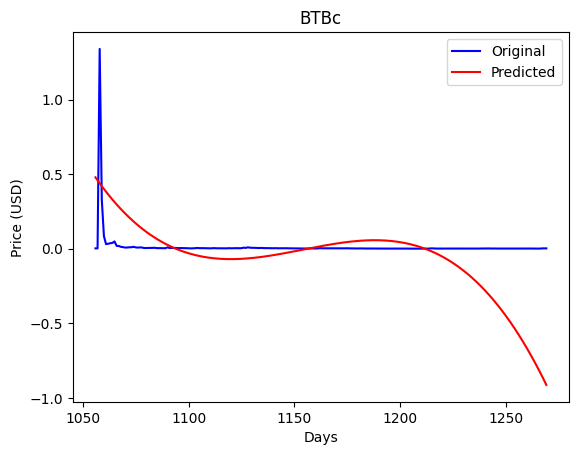

CKUSD
Mean Squared Error: 0.0002659752407643519 R-squared: -0.18605867283102295


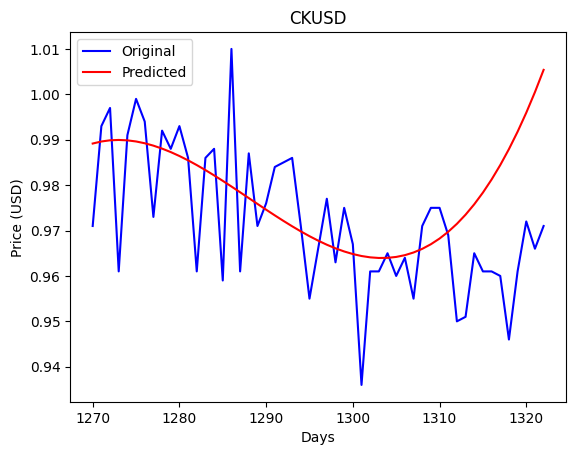

DBG
Mean Squared Error: 0.19070726582845302 R-squared: -105.98712194800385


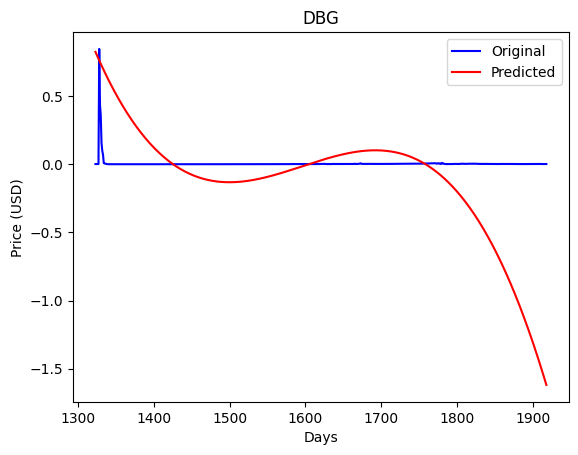

EDR
Mean Squared Error: 18460.601977287908 R-squared: -3.4952881703101513


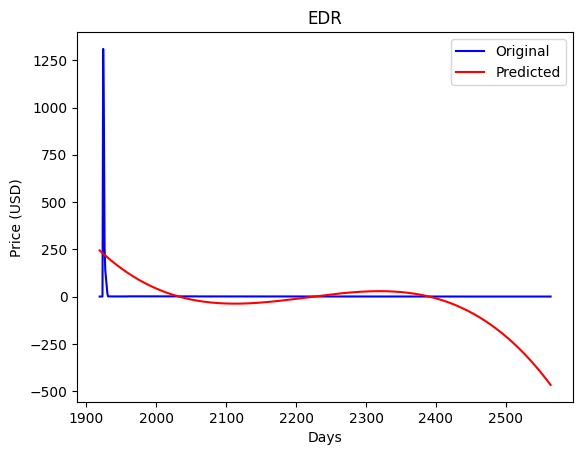

FRGC
Mean Squared Error: 2.06943172518158 R-squared: -0.17934481700307603


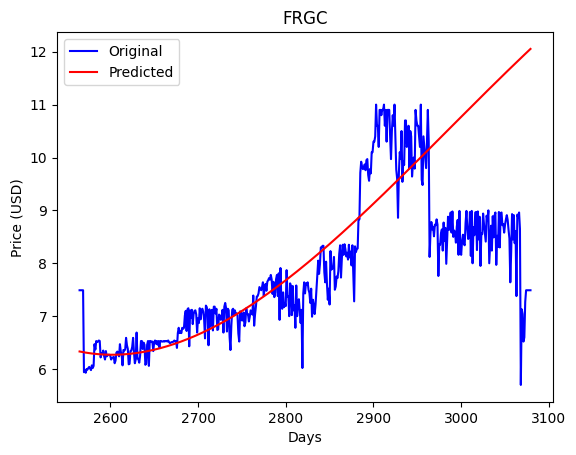

OP
Mean Squared Error: 0.04933037906626428 R-squared: -474.8981755468559


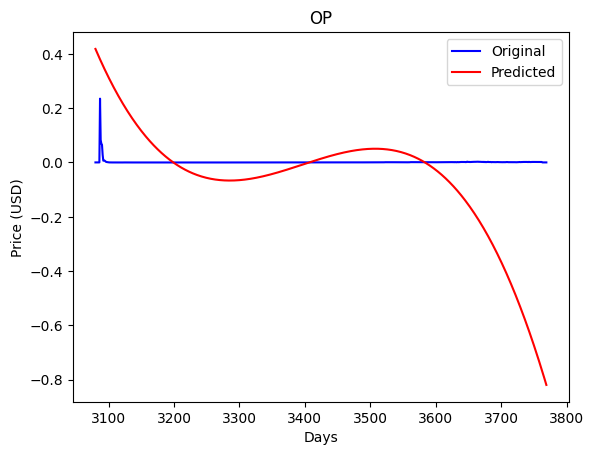

PZM
Mean Squared Error: 0.03559081021832355 R-squared: -0.09896626247344842


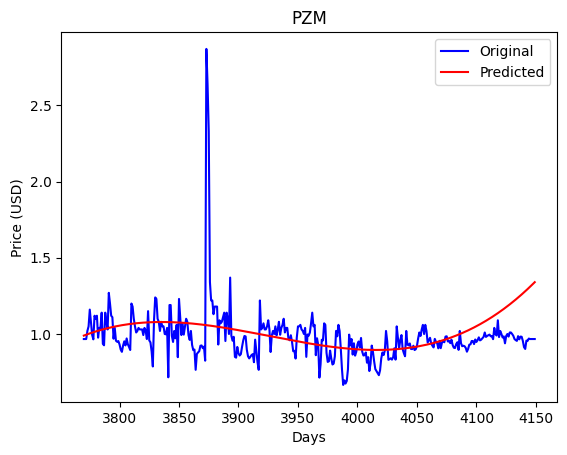

USNBT
Mean Squared Error: 0.05206110726717859 R-squared: -1.6549055347357258


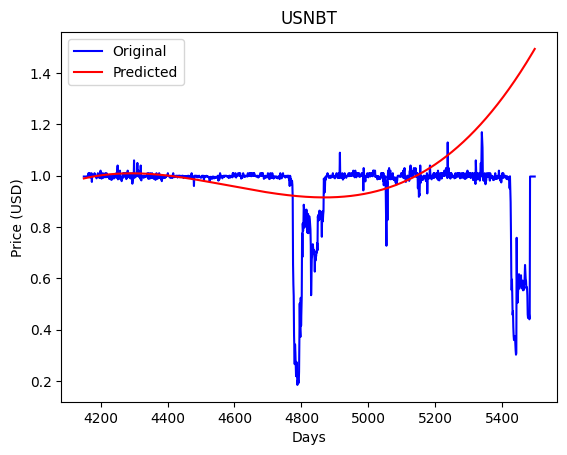

XSN
Mean Squared Error: 0.0030868778546755296 R-squared: -1.1557798695763104


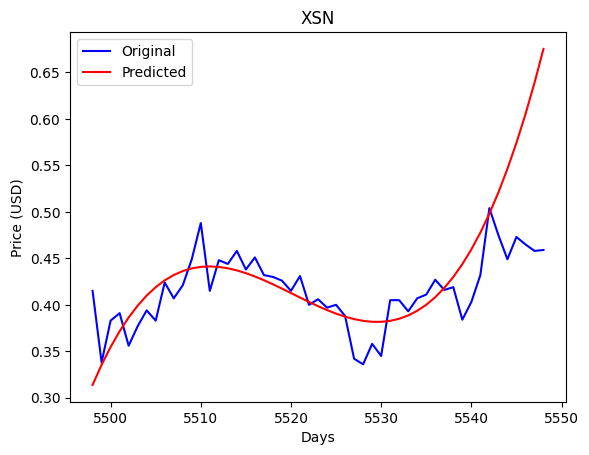

In [50]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/PolyImages/'
john_images_dir = '/content/drive/Starred/484 project/PolyImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # gather polynomial features
  poly = PolynomialFeatures(degree=3, include_bias=False)
  poly_features = poly.fit_transform(trainX)
  # create poly model
  poly_reg_model = LinearRegression()
  # fit to training data
  poly_reg_model.fit(poly_features, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # gather polynomial features
  poly_features = poly.fit_transform(testX)
  # predict testing data from instances
  polyPreds = poly_reg_model.predict(poly_features)
  # calculate and save error rate in MSE
  error = [mean_squared_error(currencies[coin]['test']['Open'], polyPreds), r2_score(currencies[coin]['test']['Open'], polyPreds)]
  errorDict[coin]['poly'] = error
  # plot predictions
  print(coin)
  print("Mean Squared Error:",error[0], "R-squared:", error[1])
  plt.plot(currencies[coin]['test']['Open'], color='b', label='Original')
  plt.plot(range(test_ind[0], test_ind.size+test_ind[0]),polyPreds, color='r', label='Predicted')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price (USD)')
  plt.title(coin)
  plt.savefig(will_images_dir+coin)
  #plt.savefig(john_images_dir+coin)
  plt.show()

## Support Vector Regression

### Collage plots

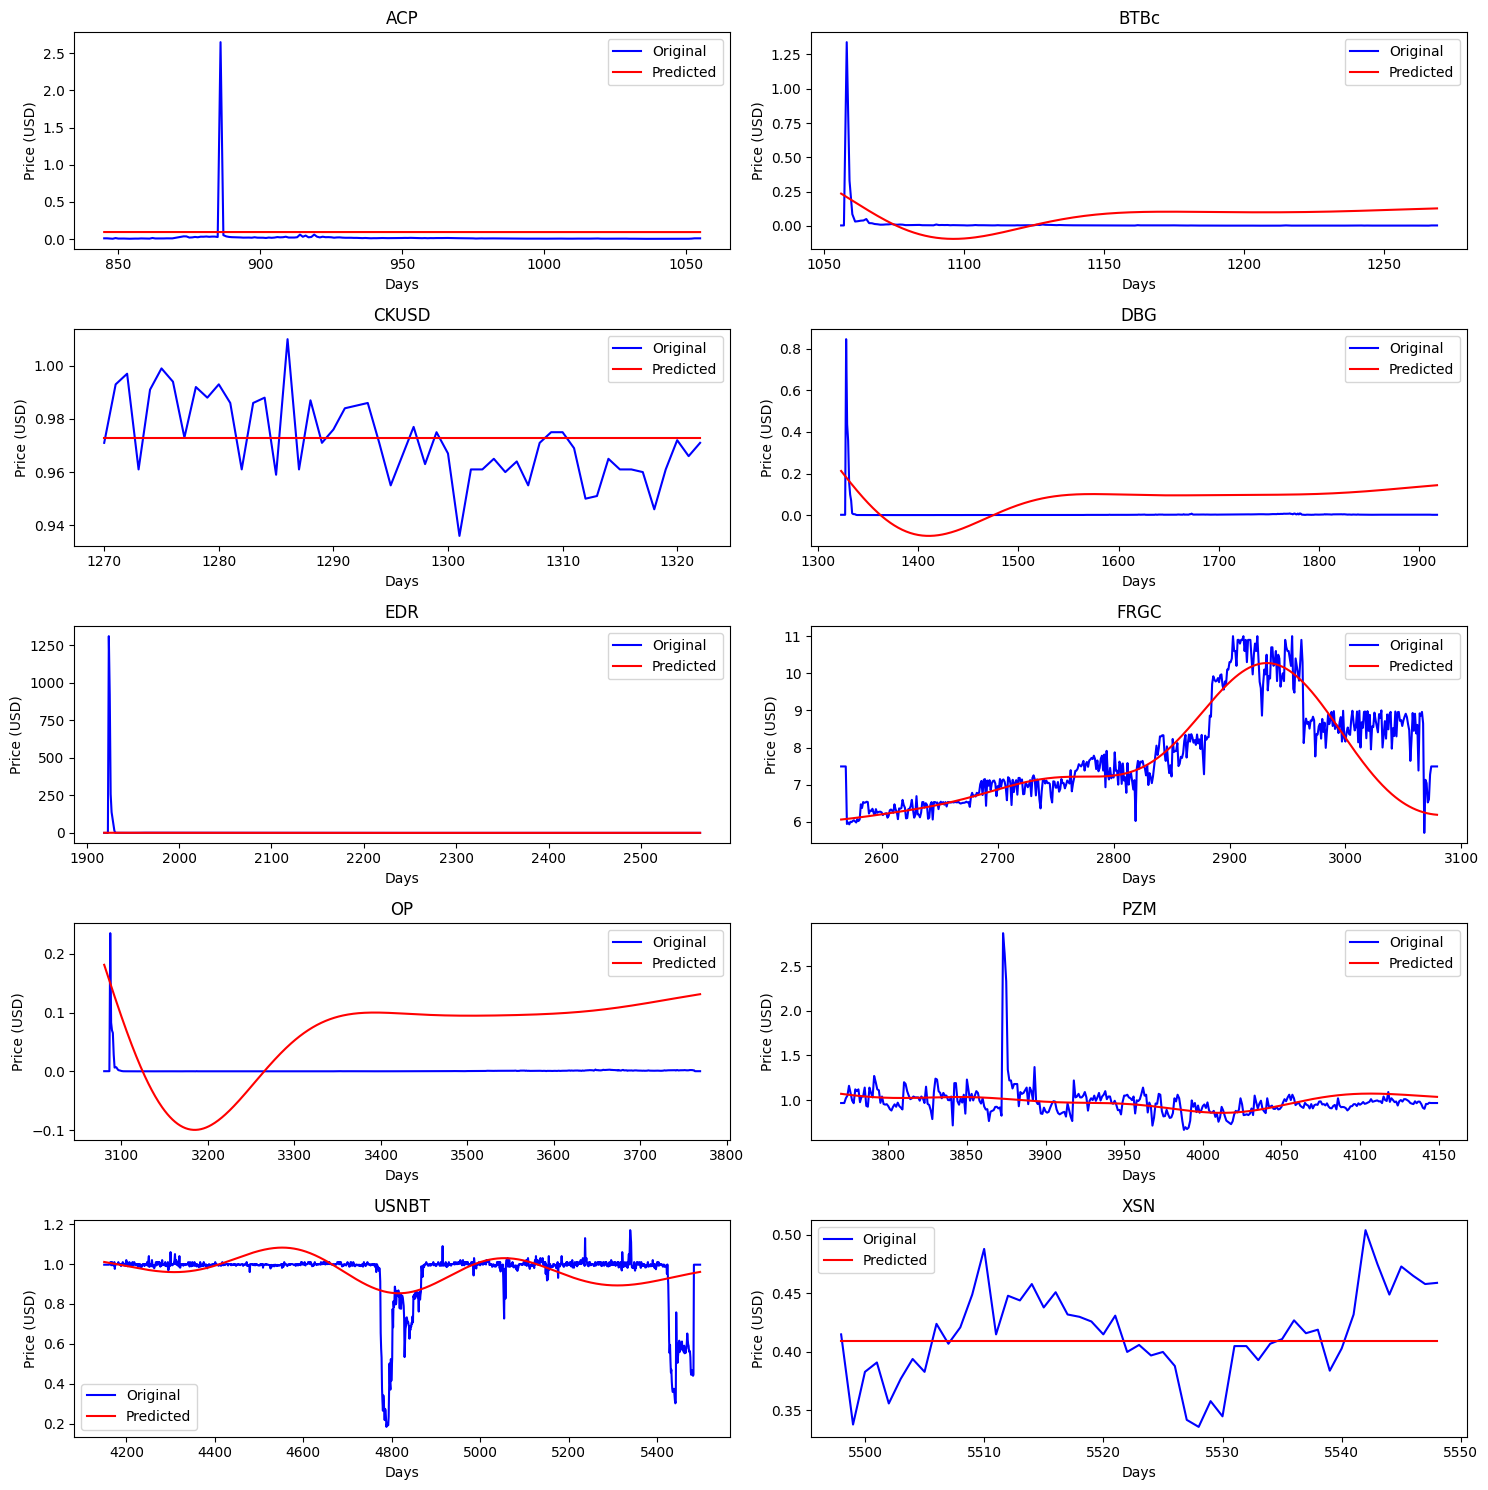

In [37]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/SVRimages/'
john_images_dir = '/content/drive/Starred/484 project/SVRimages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create SVR model
  SVR_model = svm.SVR()
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  SVR_model.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  svrPreds = SVR_model.predict(testX)
  # plot
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
  ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),svrPreds, color='r', label='Predicted')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plots

[documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)

ACP
Mean Squared Error: 0.03755807063070275 R-squared: -0.14156044348727126


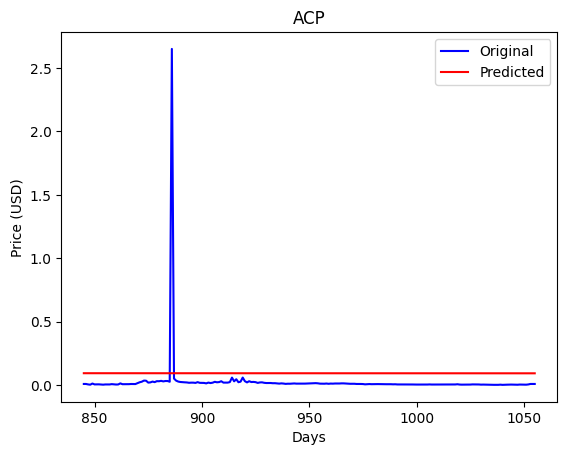

BTBc
Mean Squared Error: 0.014455425039737626 R-squared: -0.6357582527211272


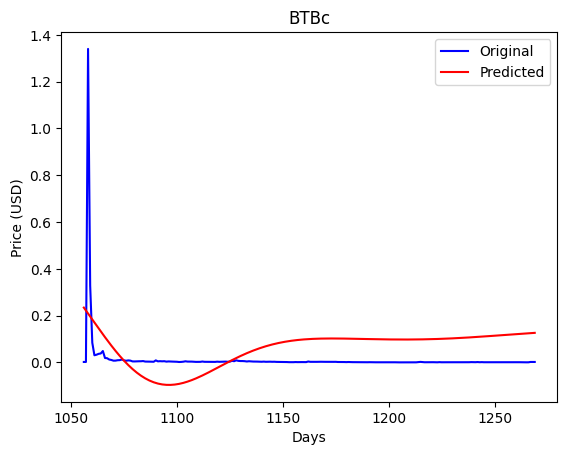

CKUSD
Mean Squared Error: 0.0002250377358490571 R-squared: -0.003506783379530587


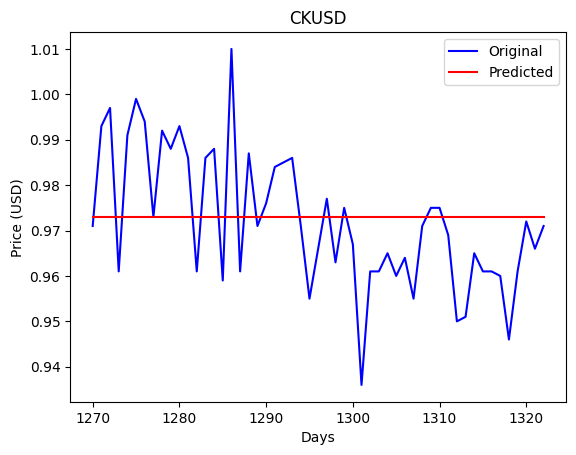

DBG
Mean Squared Error: 0.00970697144132777 R-squared: -4.445628580681902


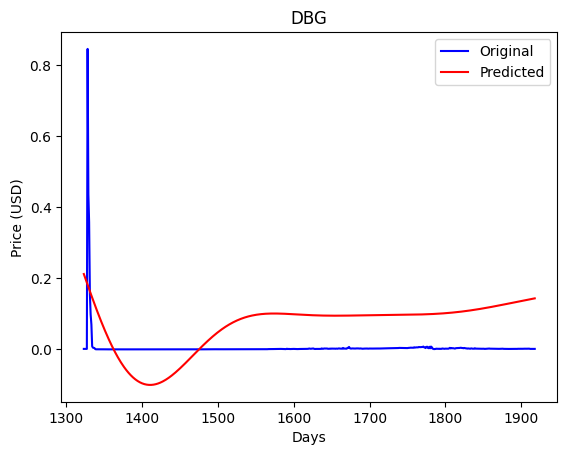

EDR
Mean Squared Error: 4120.904903491035 R-squared: -0.0034697181829304036


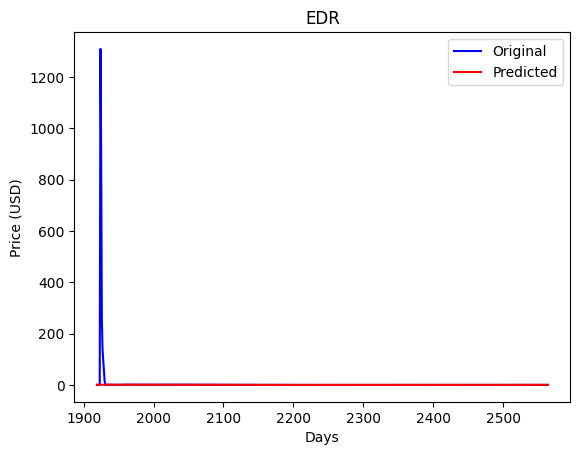

FRGC
Mean Squared Error: 0.5775809474597635 R-squared: 0.6708434066716408


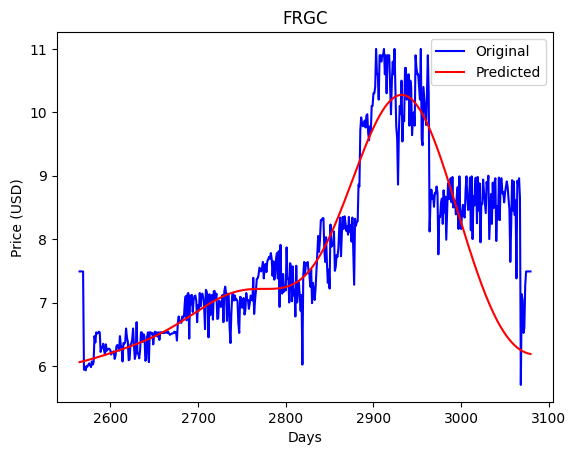

OP
Mean Squared Error: 0.008448901836413775 R-squared: -80.50792767926498


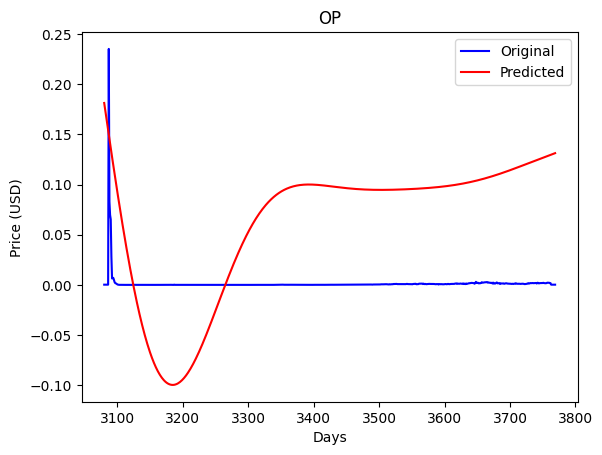

PZM
Mean Squared Error: 0.030605066744447025 R-squared: 0.054982575373366815


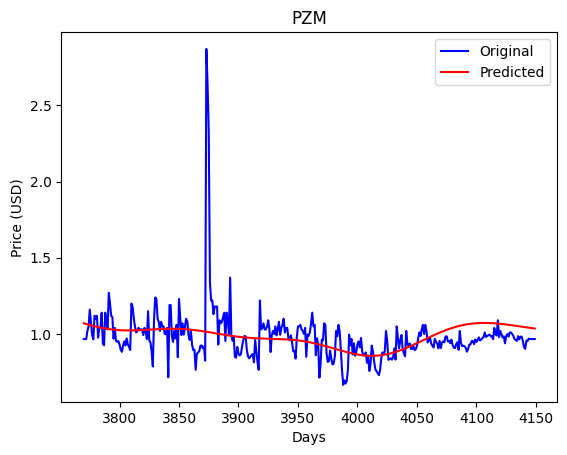

USNBT
Mean Squared Error: 0.01764157993822582 R-squared: 0.1003509015067332


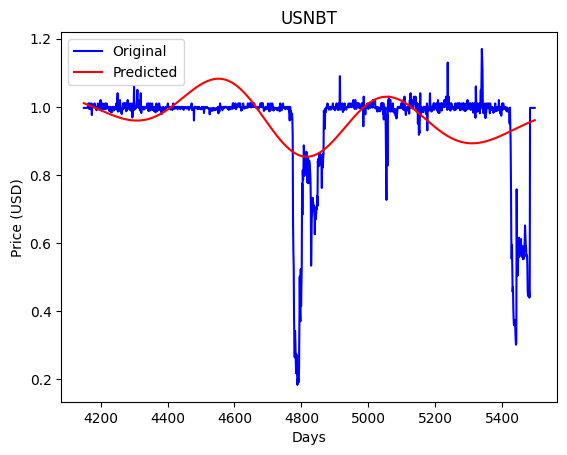

XSN
Mean Squared Error: 0.0014634656862745094 R-squared: -0.022039100610246942


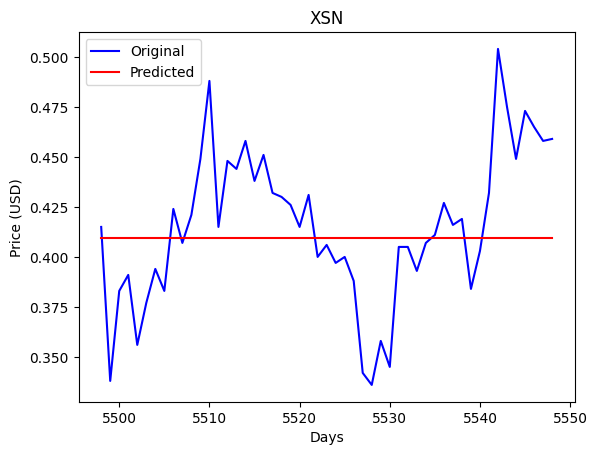

In [44]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/SVRimages/'
john_images_dir = '/content/drive/Starred/484 project/SVRimages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create SVR model
  SVR_model = svm.SVR()
  # reshape training X variable
  trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
  trainX = trainX.reshape(len(trainX), 1)
  # fit to training data
  SVR_model.fit(trainX, currencies[coin]['train']['Open'])
  # reshape testing x variable
  testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
  testX = testX.reshape(len(testX), 1)
  # predict testing data from instances
  svrPreds = SVR_model.predict(testX)
  # calculate and save error rate in MSE
  error = [mean_squared_error(currencies[coin]['test']['Open'], svrPreds), r2_score(currencies[coin]['test']['Open'], svrPreds)]
  errorDict[coin]['svr'] = error
  # plot predictions
  print(coin)
  print("Mean Squared Error:",error[0], "R-squared:", error[1])
  plt.plot(currencies[coin]['test']['Open'], color='b', label='Original')
  plt.plot(range(test_ind[0], test_ind.size+test_ind[0]),svrPreds, color='r', label='Predicted')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price (USD)')
  plt.title(coin)
  plt.savefig(will_images_dir+coin)
  #plt.savefig(john_images_dir+coin)
  plt.show()

## Multi-Linear Regression

[Implementation](https://www.w3schools.com/python/python_ml_multiple_regression.asp)

### Collage plot

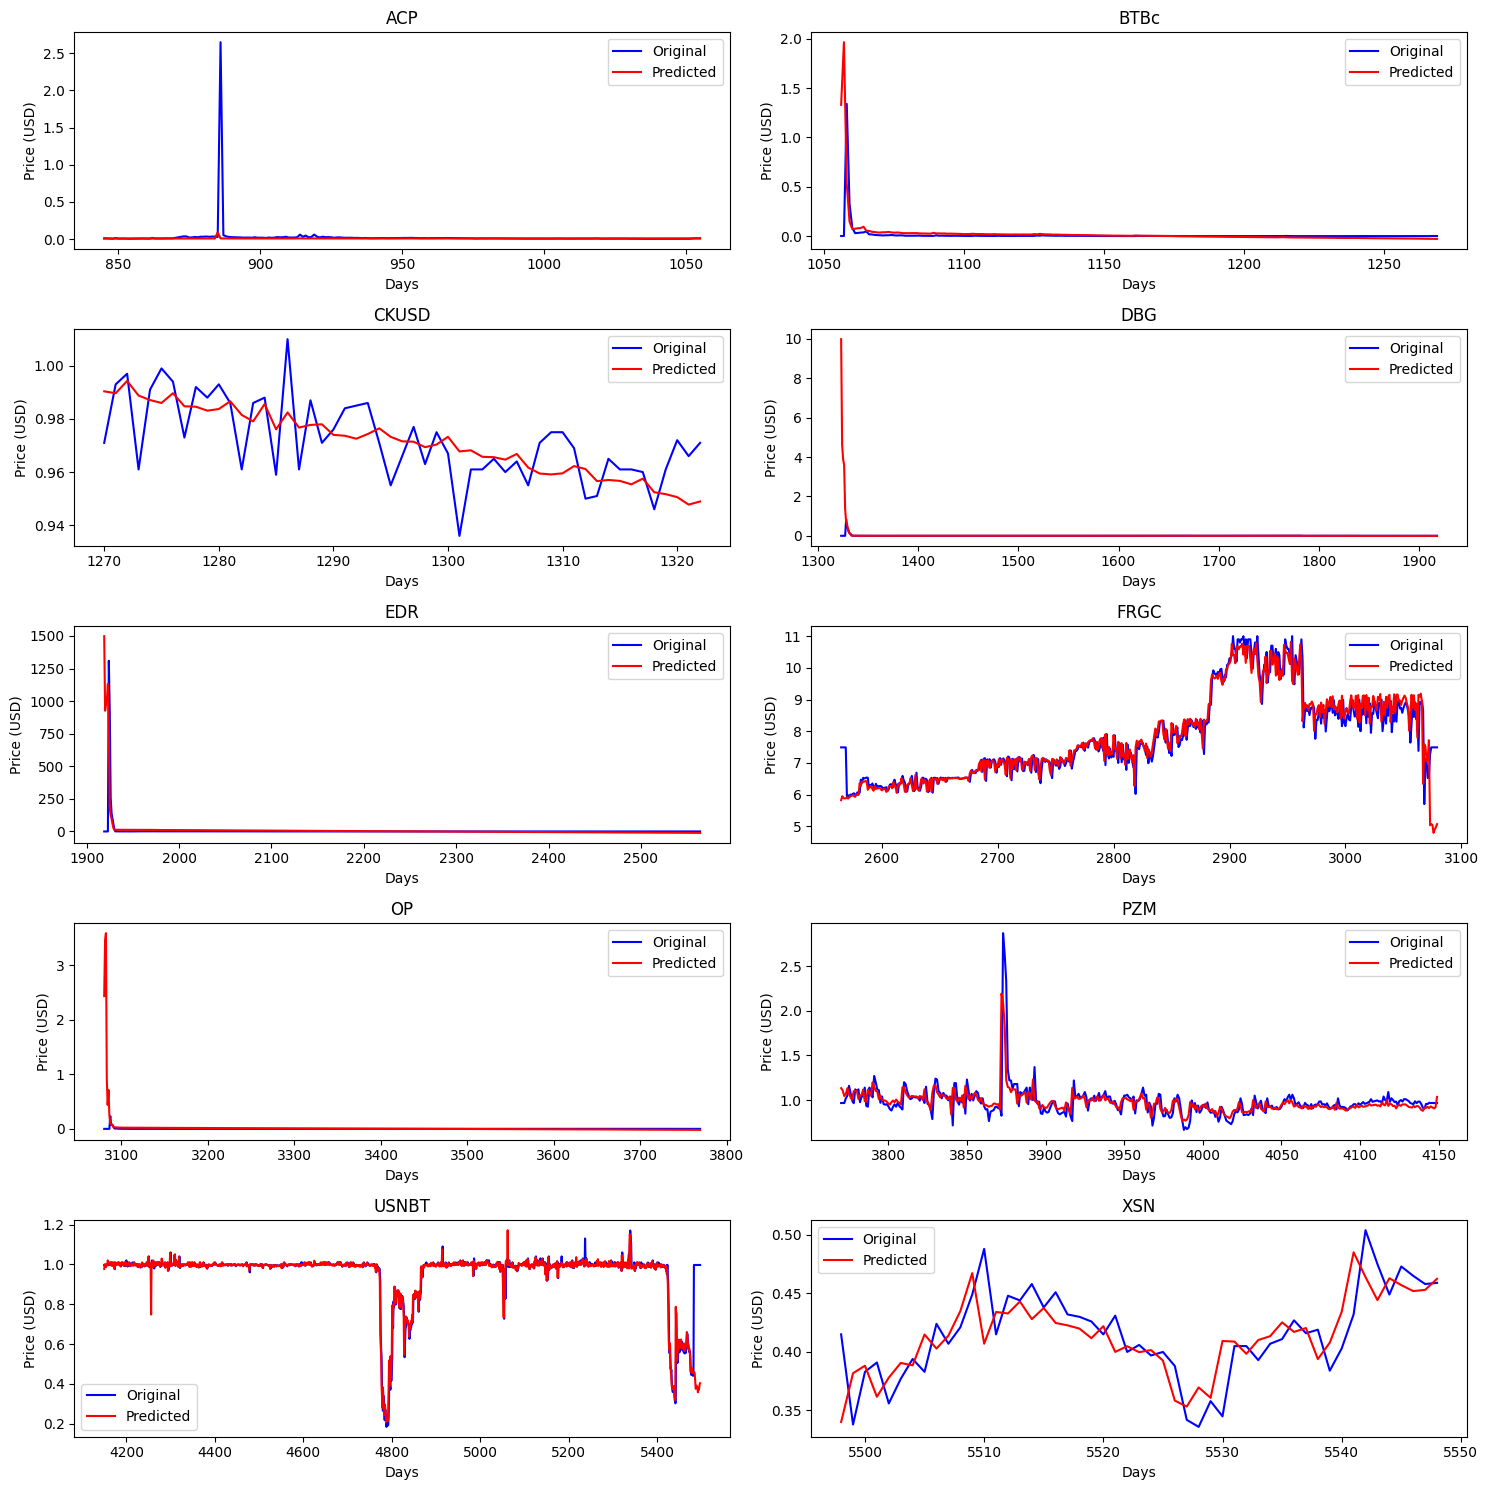

In [39]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0

will_images_dir = '/content/drive/MyDrive/CISC484/484 project/MultiImages/'
john_images_dir = '/content/drive/Starred/484 project/MultiImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create SVR model
  multiModel = linear_model.LinearRegression()
  # gather training X attributes
  trainX = currencies[coin]['train'][['Instance', 'Close']] # using instance and close value to predict open values
  # fit to training data
  multiModel.fit(trainX, currencies[coin]['train']['Open'])
  # gather testing X attributes
  testX = currencies[coin]['test'][['Instance', 'Close']]
  # predict testing data from instances
  multiPreds = multiModel.predict(testX)
  # plot
  ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
  ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),multiPreds, color='r', label='Predicted')
  ax[subs[sub][0], subs[sub][1]].legend()
  ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
  ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
  ax[subs[sub][0], subs[sub][1]].set_title(coin)
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'collage')
fig.show()

### Single plots

ACP
Mean Squared Error: 0.03323553454091611 R-squared: -0.010178928601551673


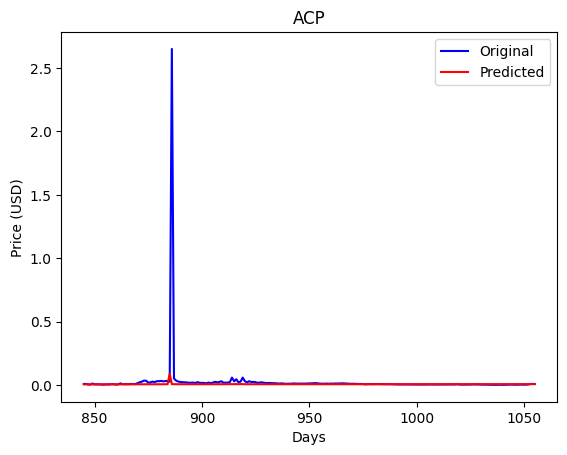

BTBc
Mean Squared Error: 0.029745040288122384 R-squared: -2.3659124512122776


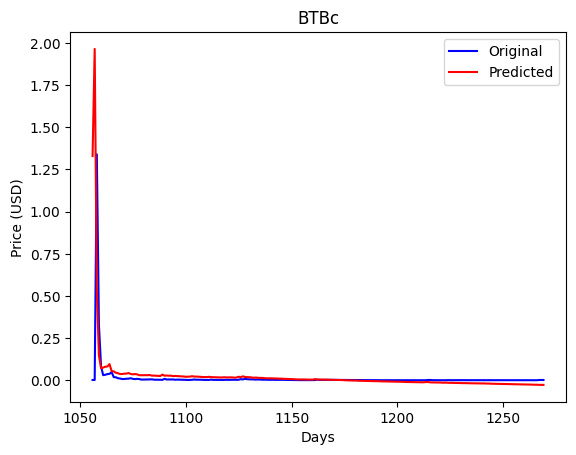

CKUSD
Mean Squared Error: 0.00015129430855040612 R-squared: 0.32533597379026236


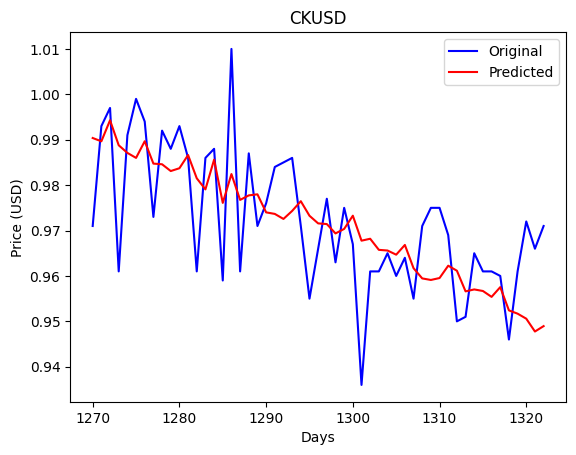

DBG
Mean Squared Error: 0.2531739498754273 R-squared: -141.03104497206283


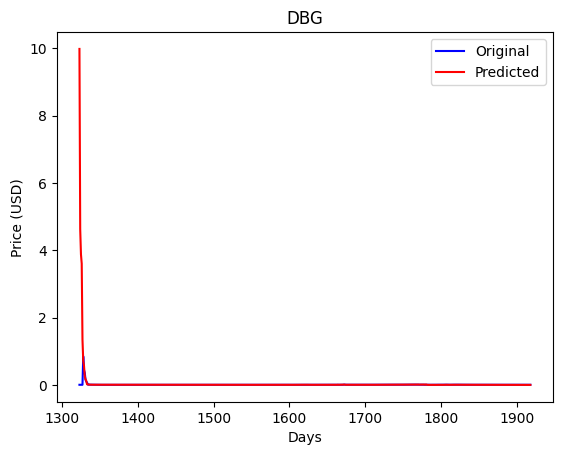

EDR
Mean Squared Error: 11245.529588136833 R-squared: -1.738366613863314


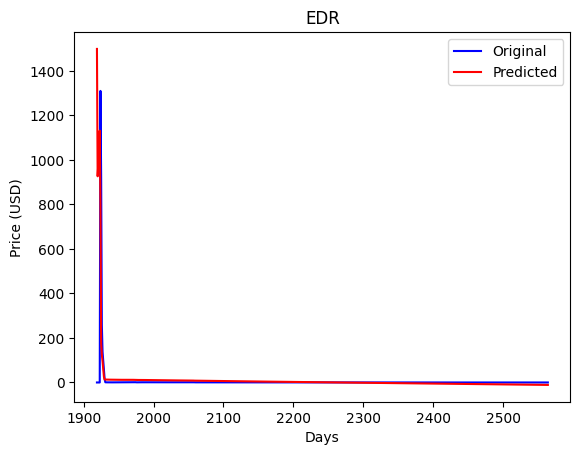

FRGC
Mean Squared Error: 0.2651014714950792 R-squared: 0.8489217872794631


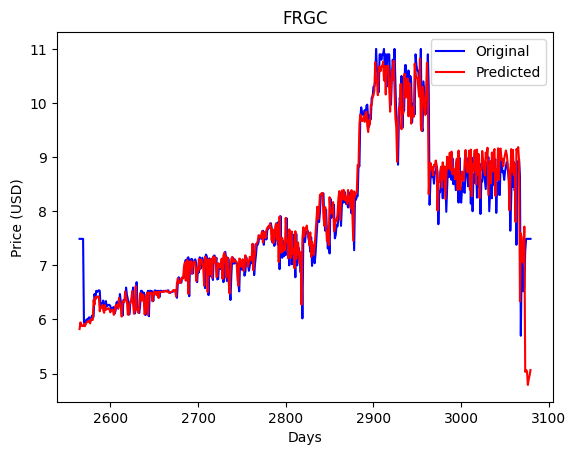

OP
Mean Squared Error: 0.046844125969142295 R-squared: -450.91288828038853


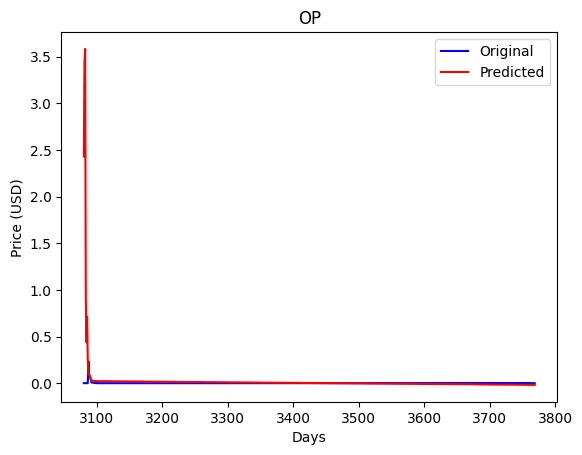

PZM
Mean Squared Error: 0.01814289564355779 R-squared: 0.43978712219421656


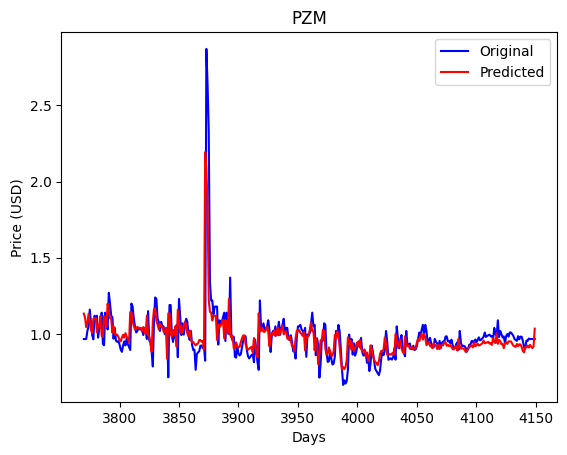

USNBT
Mean Squared Error: 0.00491629907123831 R-squared: 0.749288666726545


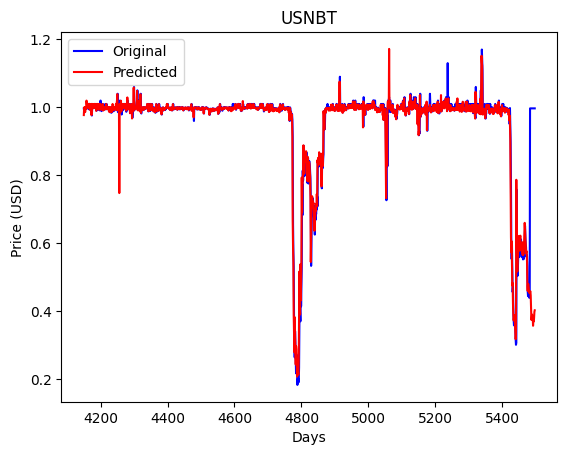

XSN
Mean Squared Error: 0.0007182377143639543 R-squared: 0.4984050295831789


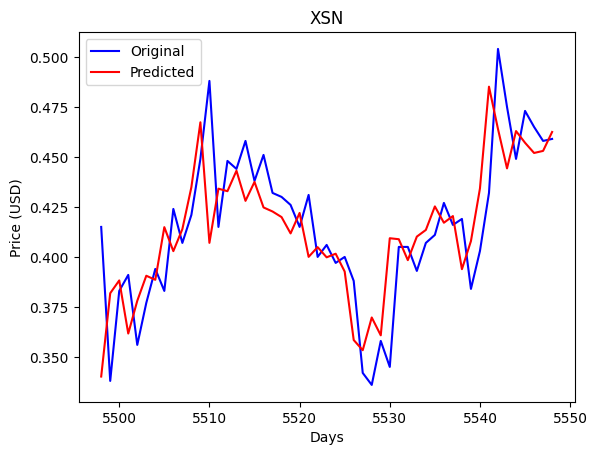

In [43]:
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/MultiImages/'
john_images_dir = '/content/drive/Starred/484 project/MultiImages/'
# iterate through every coin
for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  # create SVR model
  multiModel = linear_model.LinearRegression()
  # gather training X attributes
  trainX = currencies[coin]['train'][['Instance', 'Close']] # using instance and close value to predict open values
  # fit to training data
  multiModel.fit(trainX, currencies[coin]['train']['Open'])
  # gather testing X attributes
  testX = currencies[coin]['test'][['Instance', 'Close']]
  # predict testing data from instances
  multiPreds = multiModel.predict(testX)
  # calculate and save error rate in MSE
  error = [mean_squared_error(currencies[coin]['test']['Open'], multiPreds), r2_score(currencies[coin]['test']['Open'], multiPreds)]
  errorDict[coin]['multi'] = error
  # plot predictions
  print(coin)
  print("Mean Squared Error:",error[0], "R-squared:", error[1])
  plt.plot(currencies[coin]['test']['Open'], color='b', label='Original')
  plt.plot(range(test_ind[0], test_ind.size+test_ind[0]),multiPreds, color='r', label='Predicted')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price (USD)')
  plt.title(coin)
  plt.savefig(will_images_dir+coin)
  #plt.savefig(john_images_dir+coin)
  plt.show()

# Compare error between regressions

[Error Measure Comparison](https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/)

In [60]:
regressions = ['linear', 'lasso', 'poly', 'svr', 'multi']
print('                MSE                     R-squared')
for coin in names:
  for reg in regressions:
    print(coin, reg, errorDict[coin][reg])

                MSE                     R-squared
ACP linear [0.03360096148561545, -0.021285914078919888]
ACP lasso [0.033439656613776944, -0.016383125997945003]
ACP poly [0.033522164032022406, -0.018890901381015013]
ACP svr [0.03755807063070275, -0.14156044348727126]
ACP multi [0.03323553454091611, -0.010178928601551673]
BTBc linear [0.01148853689780381, -0.30002881206285537]
BTBc lasso [0.009445997682380226, -0.06889756763724675]
BTBc poly [0.06500531836118681, -6.3559224780847785]
BTBc svr [0.014455425039737626, -0.6357582527211272]
BTBc multi [0.029745040288122384, -2.3659124512122776]
CKUSD linear [0.00014851025217499855, 0.33775086699691326]
CKUSD lasso [0.00023844723612715586, -0.06330353008972534]
CKUSD poly [0.0002659752407643519, -0.18605867283102295]
CKUSD svr [0.0002250377358490571, -0.003506783379530587]
CKUSD multi [0.00015129430855040612, 0.32533597379026236]
DBG linear [0.013704551642714996, -6.6882783226558695]
DBG lasso [0.011891869292176675, -5.671360236983733]
DBG p

## best regressions for each coin

In [47]:
regressions = ['linear', 'lasso', 'poly', 'svr', 'multi']
mseDict = {'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None}
rDict = {'linear':None, 'lasso':None, 'poly':None, 'svr':None, 'multi':None}

print("For MSE:")
for coin in names:
  for reg in regressions:
    mseDict[reg] = errorDict[coin][reg][0]
  keymax = min(mseDict, key= lambda x: mseDict[x])
  print(keymax, "regression is best for", coin)

print("For R-squared:")
for coin in names:
  for reg in regressions:
    rDict[reg] = errorDict[coin][reg][1]
  keymax = max(rDict, key= lambda x: rDict[x])
  print(keymax, "regression is best for", coin)

For MSE:
multi regression is best for ACP
lasso regression is best for BTBc
linear regression is best for CKUSD
svr regression is best for DBG
svr regression is best for EDR
multi regression is best for FRGC
lasso regression is best for OP
multi regression is best for PZM
multi regression is best for USNBT
multi regression is best for XSN
For R-squared:
multi regression is best for ACP
lasso regression is best for BTBc
linear regression is best for CKUSD
svr regression is best for DBG
svr regression is best for EDR
multi regression is best for FRGC
lasso regression is best for OP
multi regression is best for PZM
multi regression is best for USNBT
multi regression is best for XSN


## worst regressions for each coin

In [48]:
print("For MSE:")
for coin in names:
  for reg in regressions:
    mseDict[reg] = errorDict[coin][reg][0]
  keymax = max(mseDict, key= lambda x: mseDict[x])
  print(keymax, "regression is worst for", coin)

print("For R-squared:")
for coin in names:
  for reg in regressions:
    rDict[reg] = errorDict[coin][reg][1]
  keymax = min(rDict, key= lambda x: rDict[x])
  print(keymax, "regression is worst for", coin)

For MSE:
svr regression is worst for ACP
poly regression is worst for BTBc
poly regression is worst for CKUSD
poly regression is worst for DBG
poly regression is worst for EDR
poly regression is worst for FRGC
poly regression is worst for OP
poly regression is worst for PZM
poly regression is worst for USNBT
poly regression is worst for XSN
For R-squared:
svr regression is worst for ACP
poly regression is worst for BTBc
poly regression is worst for CKUSD
poly regression is worst for DBG
poly regression is worst for EDR
poly regression is worst for FRGC
poly regression is worst for OP
poly regression is worst for PZM
poly regression is worst for USNBT
poly regression is worst for XSN


# Best for each coin

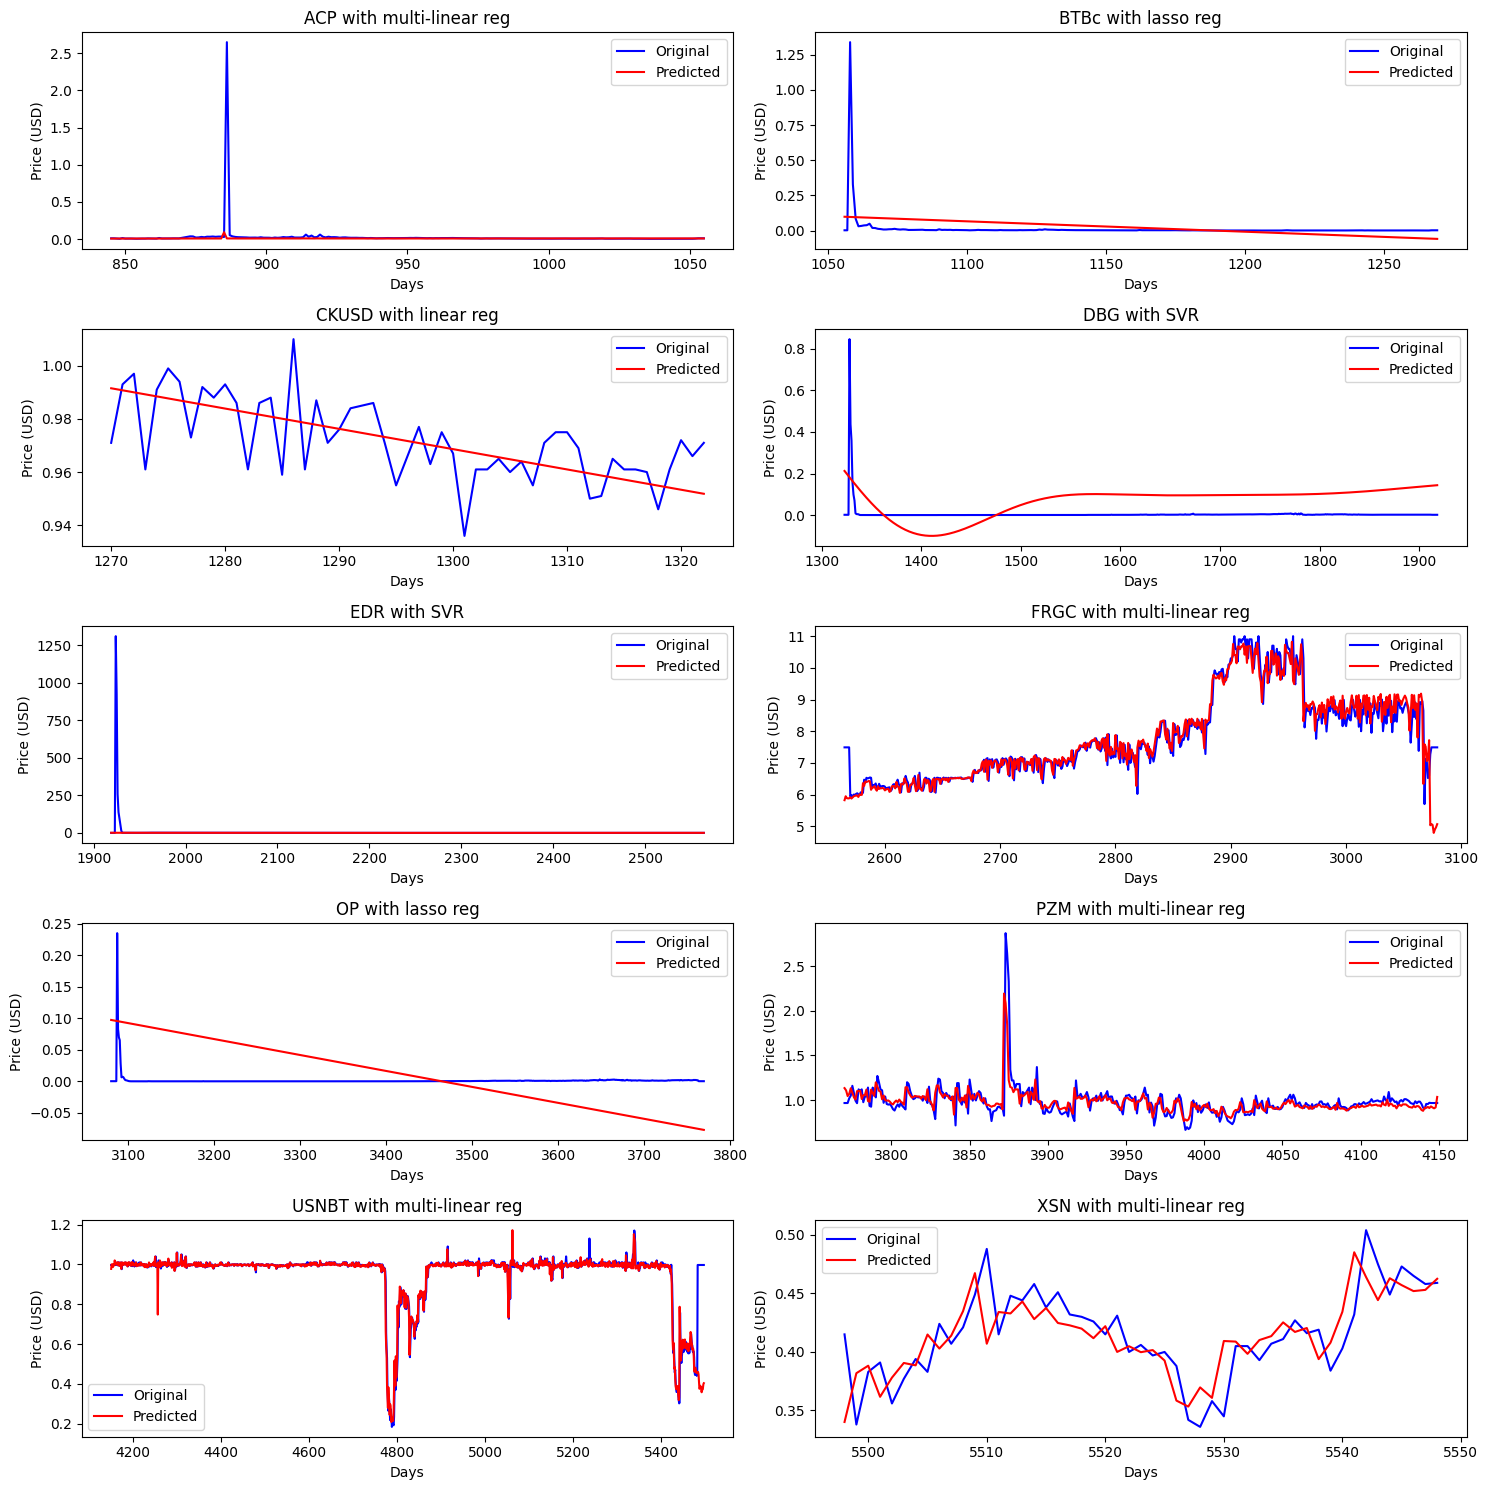

In [53]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
subs = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0], [3,1], [4,0], [4,1]]
sub = 0
will_images_dir = '/content/drive/MyDrive/CISC484/484 project/'

for coin in names:
  test_ind = currencies[coin]['test']['Instance'].index
  if coin == 'ACP' or coin == 'FRGC' or coin == 'PZM' or coin == 'USNBT' or coin == 'XSN': # multi regression
    multiModel = linear_model.LinearRegression()
    trainX = currencies[coin]['train'][['Instance', 'Close']] # using instance and close value to predict open values
    multiModel.fit(trainX, currencies[coin]['train']['Open'])
    testX = currencies[coin]['test'][['Instance', 'Close']]
    multiPreds = multiModel.predict(testX)
    ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
    ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),multiPreds, color='r', label='Predicted')
    ax[subs[sub][0], subs[sub][1]].legend()
    ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
    ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
    ax[subs[sub][0], subs[sub][1]].set_title(coin + " with multi-linear reg")
  elif coin == 'BTBc' or coin == 'OP': # lasso regression
    lassoModel = linear_model.Lasso(alpha=1.0)
    trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
    trainX = trainX.reshape(len(trainX), 1)
    lassoModel.fit(trainX, currencies[coin]['train']['Open'])
    testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
    testX = testX.reshape(len(testX), 1)
    lassoPreds = lassoModel.predict(testX)
    ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
    ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),lassoPreds, color='r', label='Predicted')
    ax[subs[sub][0], subs[sub][1]].legend()
    ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
    ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
    ax[subs[sub][0], subs[sub][1]].set_title(coin + " with lasso reg")
  elif coin == 'CKUSD': # linear regression
    linearModel = LinearRegression()
    trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
    trainX = trainX.reshape(len(trainX), 1)
    linearModel.fit(trainX, currencies[coin]['train']['Open'])
    testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
    testX = testX.reshape(len(testX), 1)
    linearPreds = linearModel.predict(testX)
    ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
    ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),linearPreds, color='r', label='Predicted')
    ax[subs[sub][0], subs[sub][1]].legend()
    ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
    ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
    ax[subs[sub][0], subs[sub][1]].set_title(coin + " with linear reg")
  elif coin == 'DBG' or coin == 'EDR': # SVR
    SVR_model = svm.SVR()
    trainX = np.array([float(i) for i in range(len(currencies[coin]['train']['Instance']))])
    trainX = trainX.reshape(len(trainX), 1)
    SVR_model.fit(trainX, currencies[coin]['train']['Open'])
    testX = np.array([float(i) for i in range(len(currencies[coin]['test']['Instance']))])
    testX = testX.reshape(len(testX), 1)
    svrPreds = SVR_model.predict(testX)
    ax[subs[sub][0], subs[sub][1]].plot(currencies[coin]['test']['Open'], color='b', label='Original')
    ax[subs[sub][0], subs[sub][1]].plot(range(test_ind[0], test_ind.size+test_ind[0]),svrPreds, color='r', label='Predicted')
    ax[subs[sub][0], subs[sub][1]].legend()
    ax[subs[sub][0], subs[sub][1]].set_xlabel('Days')
    ax[subs[sub][0], subs[sub][1]].set_ylabel('Price (USD)')
    ax[subs[sub][0], subs[sub][1]].set_title(coin+" with SVR")
  sub += 1
fig.tight_layout()
fig.savefig(will_images_dir+'BestForEach')
fig.show()